## Data Preprocessing

In [1]:
import GEOparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import requests
import os
from datetime import datetime

In [2]:
def download_geo_dataset(geo_accession):
    """
    Download GEO dataset and extract metadata
    """
    print(f"Downloading GEO dataset: {geo_accession}")
    
    # Download the dataset
    gse = GEOparse.get_GEO(geo=geo_accession, destdir="./geo_data/")
    
    print(f"Dataset title: {gse.metadata['title'][0]}")
    print(f"Number of samples: {len(gse.gsms)}")
    print(f"Platform: {list(gse.gpls.keys())}")
    
    return gse

def inspect_sample_metadata(gse):
    """
    Inspect sample metadata to understand data structure
    """
    print("\n=== SAMPLE METADATA INSPECTION ===")
    
    sample_info = []
    for sample_id, sample in gse.gsms.items():
        characteristics = sample.metadata.get('characteristics_ch1', [])
        
        sample_data = {
            'sample_id': sample_id,
            'title': sample.metadata.get('title', [''])[0],
            'characteristics': characteristics
        }
        sample_info.append(sample_data)
    
    # Convert to DataFrame for easy viewing
    sample_df = pd.DataFrame(sample_info)
    
    print(f"First few samples:")
    print(sample_df.head())
    
    # Print unique characteristics to understand data structure
    print(f"\nExample characteristics from first sample:")
    if len(sample_info) > 0:
        for char in sample_info[0]['characteristics']:
            print(f"  - {char}")
    
    return sample_df


In [3]:
geo_accession = "GSE165856"
gse = download_geo_dataset(geo_accession)
sample_df = inspect_sample_metadata(gse)

04-Aug-2025 11:44:54 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE165nnn/GSE165856/soft/GSE165856_family.soft.gz to ./geo_data/GSE165856_family.soft.gz


100%|██████████| 5.63k/5.63k [00:00<00:00, 11.9kB/s]
04-Aug-2025 11:44:56 DEBUG downloader - Size validation passed
04-Aug-2025 11:44:56 DEBUG downloader - Moving /tmp/tmpdgnluwvb to /cosybio/project/mabouzid/EEI_networks/EEI-Conservation-main/mm_RNA_seq_data/geo_data/GSE165856_family.soft.gz
04-Aug-2025 11:44:56 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE165nnn/GSE165856/soft/GSE165856_family.soft.gz
04-Aug-2025 11:44:56 INFO GEOparse - Parsing ./geo_data/GSE165856_family.soft.gz: 
04-Aug-2025 11:44:56 DEBUG GEOparse - DATABASE: GeoMiame
04-Aug-2025 11:44:56 DEBUG GEOparse - SERIES: GSE165856
04-Aug-2025 11:44:56 DEBUG GEOparse - PLATFORM: GPL21103
04-Aug-2025 11:44:56 DEBUG GEOparse - SAMPLE: GSM5051435
04-Aug-2025 11:44:56 DEBUG GEOparse - SAMPLE: GSM5051436
04-Aug-2025 11:44:56 DEBUG GEOparse - SAMPLE: GSM5051437
04-Aug-2025 11:44:56 DEBUG GEOparse - SAMPLE: GSM5051438
04-Aug-2025 11:44:56 DEBUG GEOparse - SAMPLE: GSM5051439
04-Aug-2025 11:4

Dataset title: Blocking ActRIIB signaling and restoring appetite reverses cachexia and improves survival in mice with lung cancer
Number of samples: 51
Platform: ['GPL21103']

=== SAMPLE METADATA INSPECTION ===
First few samples:
    sample_id            title  \
0  GSM5051435  gWAT_-CACS_rep1   
1  GSM5051436  gWAT_-CACS_rep2   
2  GSM5051437  gWAT_-CACS_rep3   
3  GSM5051438  gWAT_-CACS_rep4   
4  GSM5051439  gWAT_+CACS_rep1   

                                     characteristics  
0  [Sex: M, cacs status: Negative, weight loss: 4...  
1  [Sex: M, cacs status: Negative, weight loss: -...  
2  [Sex: M, cacs status: Negative, weight loss: 0...  
3  [Sex: M, cacs status: Negative, weight loss: -...  
4  [Sex: M, cacs status: Positive, weight loss: -...  

Example characteristics from first sample:
  - Sex: M
  - cacs status: Negative
  - weight loss: 4.6%
  - sequencing batch: Marcus5878_2018_05_24


In [6]:
def extract_survival_data(gse):
    """
    Extract cachexia and outcome data from GEO metadata
    """
    print("\n=== EXTRACTING CACHEXIA DATA ===")
    
    cachexia_data = []
    
    for sample_id, sample in gse.gsms.items():
        characteristics = sample.metadata.get('characteristics_ch1', [])
        
        # Initialize variables
        sex = None
        cachexia_status = None
        weight_loss = None
        sequencing_batch = None
        
        # Parse characteristics based on actual data structure
        for char in characteristics:
            char_lower = char.lower()
            
            # Extract sex
            if 'sex:' in char_lower:
                sex = char.split(':')[-1].strip()
            
            # Extract cachexia status
            elif 'cacs status:' in char_lower:
                cachexia_status = char.split(':')[-1].strip()
            
            # Extract weight loss
            elif 'weight loss:' in char_lower:
                weight_loss_str = char.split(':')[-1].strip()
                # Remove % sign and convert to float
                weight_loss = float(weight_loss_str.replace('%', '')) if weight_loss_str != '' else None
            
            # Extract sequencing batch
            elif 'sequencing batch:' in char_lower:
                sequencing_batch = char.split(':')[-1].strip()
        
        cachexia_data.append({
            'sample_id': sample_id,
            'sex': sex,
            'cachexia_status': cachexia_status,
            'weight_loss_percent': weight_loss,
            'sequencing_batch': sequencing_batch
        })
    
    cachexia_df = pd.DataFrame(cachexia_data)
    
    print(f"Cachexia data extracted for {len(cachexia_df)} samples")
    print(f"Samples with sex info: {cachexia_df['sex'].notna().sum()}")
    print(f"Samples with cachexia status: {cachexia_df['cachexia_status'].notna().sum()}")
    print(f"Samples with weight loss data: {cachexia_df['weight_loss_percent'].notna().sum()}")
    
    return cachexia_df

def extract_numeric_value(text):
    """Extract numeric value from text"""
    import re
    numbers = re.findall(r'\d+\.?\d*', text)
    return float(numbers[0]) if numbers else None

def parse_survival_event(text):
    """Parse survival event (1 for death/event, 0 for censored)"""
    text_lower = text.lower()
    if any(word in text_lower for word in ['dead', 'death', 'died', 'event']):
        return 1
    elif any(word in text_lower for word in ['alive', 'censored', 'no event']):
        return 0
    else:
        return None

In [10]:
# Extract survival data
survival_df = extract_survival_data(gse)

# Display summary
print("\nSurvival data summary:")
print(survival_df.groupby('cachexia_status')['weight_loss_percent'].describe())


=== EXTRACTING CACHEXIA DATA ===
Cachexia data extracted for 51 samples
Samples with sex info: 51
Samples with cachexia status: 51
Samples with weight loss data: 51

Survival data summary:
                 count       mean       std    min    25%     50%   75%    max
cachexia_status                                                               
Negative          25.0  -5.684000  5.156998 -14.50 -10.93  -4.600  -2.0   4.60
Positive          26.0 -30.743462  2.586448 -37.22 -32.00 -29.845 -29.0 -27.41


In [8]:
survival_df.head()

,sample_id,sex,cachexia_status,weight_loss_percent,sequencing_batch
0,GSM5051435,M,Negative,4.6,Marcus5878_2018_05_24
1,GSM5051436,M,Negative,-4.6,Marcus5878_2018_05_24
2,GSM5051437,M,Negative,0.3,Marcus5878_2018_05_24
3,GSM5051438,M,Negative,-5.7,Marcus5878_2018_05_24
4,GSM5051439,M,Positive,-36.7,Marcus5878_2018_05_24


In [ ]:
import requests
import gzip
import os

In [18]:
def load_expression_data_corrected():
    """
    Load the expression data with correct parsing
    """
    filename = "GSE165856_Goncalves-MG-7833_2019_10_25_HTSeq.gene.counts.csv"
    filepath = f"./geo_data/{filename}"
    
    try:
        # First try with multi-index header
        expression_df = pd.read_csv(filepath, sep=',', index_col=0, header=[0,1])
        print(f"Successfully loaded expression data with multi-index: {expression_df.shape}")
        return expression_df
    except Exception as e:
        print(f"Multi-index parsing failed: {e}")
        try:
            # Try with single header, skip first row
            expression_df = pd.read_csv(filepath, sep=',', index_col=0, skiprows=1)
            print(f"Successfully loaded expression data with single header: {expression_df.shape}")
            return expression_df
        except Exception as e2:
            print(f"Single header parsing also failed: {e2}")
            return None

In [19]:
# Load the expression data correctly
expression_df = load_expression_data_corrected()

# Basic quality control
if expression_df is not None:
    print(f"\nExpression data summary:")
    print(f"Genes: {expression_df.shape[0]}")
    print(f"Samples: {expression_df.shape[1]}")
    print(f"Expression range: {expression_df.min().min():.2f} to {expression_df.max().max():.2f}")
    
    # Check for log transformation
    if expression_df.max().max() > 50:
        print("Data appears to be raw counts - will need normalization")
    else:
        print("Data appears to be log-transformed or normalized")
        
    # Show first few rows and columns
    print(f"\nFirst few genes and samples:")
    print(expression_df.iloc[:5, :5])

Successfully loaded expression data with multi-index: (43629, 23)

Expression data summary:
Genes: 43629
Samples: 23
Expression range: 0.00 to 2101505.00
Data appears to be raw counts - will need normalization

First few genes and samples:
                   gastro_-CACS_rep1 gWAT_+CACS_rep5 gastro_+CACS_rep5  \
                                1_S1          23_S23            10_S10   
ENSMUSG00000000001               559            3275               995   
ENSMUSG00000000003                 0               0                 0   
ENSMUSG00000000028               112             310               138   
ENSMUSG00000000031             15856              17             12892   
ENSMUSG00000000037                 3              20                 0   

                   gWAT_-CACS_rep10 gWAT_-CACS_rep9  
                             22_S22          21_S21  
ENSMUSG00000000001             4636            3550  
ENSMUSG00000000003                0               0  
ENSMUSG00000000028       

In [20]:
expression_df.head()

,gastro_-CACS_rep1,gWAT_+CACS_rep5,gastro_+CACS_rep5,gWAT_-CACS_rep10,gWAT_-CACS_rep9,gWAT_+CACS_rep6,gastro_-CACS_rep4,gastro_-CACS_rep5,gWAT_+CACS_rep8,gastro_-CACS_rep3,...,gastro_-CACS_rep2,gastro_+CACS_rep2,gastro_+CACS_rep4,gastro_+CACS_rep1,Tumor_-CACS_rep9,Tumor_-CACS_rep10,Tumor_+CACS_rep9,Tumor_+CACS_rep10,Tumor_+CACS_rep11,Tumor_+CACS_rep12
,1_S1,23_S23,10_S10,22_S22,21_S21,24_S24,4_S4,5_S5,27_S26,3_S3,...,2_S2,7_S7,9_S9,6_S6,29_S28,30_S29,34_S30,35_S31,36_S32,38_S34
ENSMUSG00000000001,559,3275,995,4636,3550,3507,673,553,2811,659,...,590,693,658,727,3302,4203,5919,4244,4939,5430
ENSMUSG00000000003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000028,112,310,138,393,315,265,79,80,284,69,...,58,99,98,120,111,194,331,185,253,189
ENSMUSG00000000031,15856,17,12892,48,51,15,11906,14111,21,9828,...,10737,14892,16055,15904,26,31,70,55,124,37
ENSMUSG00000000037,3,20,0,29,135,28,1,2,27,3,...,3,1,0,2,20,21,12,11,5,9


In [87]:
expression_df.head

<bound method NDFrame.head of                    gastro_-CACS_rep1 gWAT_+CACS_rep5 gastro_+CACS_rep5  \
                                1_S1          23_S23            10_S10   
ENSMUSG00000000001               559            3275               995   
ENSMUSG00000000003                 0               0                 0   
ENSMUSG00000000028               112             310               138   
ENSMUSG00000000031             15856              17             12892   
ENSMUSG00000000037                 3              20                 0   
...                              ...             ...               ...   
ENSMUSG00000104523                 0               0                 0   
ENSMUSG00000104524                 0               2                 0   
ENSMUSG00000104525                 0               0                 0   
ENSMUSG00000104526                 0               0                 0   
ENSMUSG00000104527                 0               0                 0   

       

### Step 5: Map to Mouse Exons (Using Data from pipeline 3)

In [24]:
def create_gene_to_exon_mapping(gtf_file, output_file):
    """
    Extracts gene-to-exon mapping from a GTF file and writes it to a TSV file.
    Each row will be: gene_id \t exon_id
    """
    import gzip

    def parse_attributes(attr_str):
        """Parse GTF attribute string into a dictionary"""
        attrs = {}
        for attr in attr_str.strip().split(';'):
            if attr.strip():
                key, val = attr.strip().split(' ', 1)
                attrs[key] = val.strip('"')
        return attrs

    mapping = []

    # Open GTF (supports both plain and gzipped)
    opener = gzip.open if gtf_file.endswith('.gz') else open
    with opener(gtf_file, 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue
            cols = line.strip().split('\t')
            if cols[2] == 'exon':
                attr = parse_attributes(cols[8])
                gene_id = attr.get('gene_id')
                exon_id = attr.get('exon_id')
                if gene_id and exon_id:
                    mapping.append((gene_id, exon_id))

    # Write to TSV
    with open(output_file, 'w') as out:
        out.write("gene_id\texon_id\n")
        for gene, exon in mapping:
            out.write(f"{gene}\t{exon}\n")

    print(f"✅ Mapping written to: {output_file}")


In [25]:
create_gene_to_exon_mapping(
    gtf_file="./geo_data/Mus_musculus.GRCm39.114.gtf",
    output_file="gene_to_exon_mapping_mouse.tsv"
)

✅ Mapping written to: gene_to_exon_mapping_mouse.tsv


In [28]:
def load_your_mouse_data():
    """
    Loading mouse exon mapping and EEI network data
    """
    print("\n=== LOADING YOUR MOUSE EEI DATA ===")
    
    # Load mouse exon mapping
    mouse_exon_map_file = "./geo_data/gene_to_exon_mapping_mouse.tsv"
    
    try:
        mouse_exon_map = pd.read_csv(mouse_exon_map_file, sep='\t')
        print(f"Loaded mouse exon mapping: {len(mouse_exon_map)} entries")
    except:
        print(f"Could not load {mouse_exon_map_file}")
        return None, None
    
    # Load mouse EEI network (using PISA as example)
    mouse_eei_file = "/cosybio/project/mabouzid/EEI_networks/EEI-Conservation-main/data/PISA_results_mm/PISA_networks_filtered/PISA_EEIN_0.5.txt"
    
    try:
        mouse_eei_df = pd.read_csv(mouse_eei_file, sep='\t')
        print(f"Loaded mouse EEI network: {len(mouse_eei_df)} interactions")
    except:
        print(f"Could not load {mouse_eei_file}")
        return mouse_exon_map, None
    
    return mouse_exon_map, mouse_eei_df

def convert_gene_ids_to_symbols(expression_df):
    """
    Convert gene IDs to gene symbols for mapping
    """
    print("\n=== CONVERTING GENE IDs TO SYMBOLS ===")
    
    # Check what type of gene IDs we have
    sample_ids = expression_df.index[:10]
    print(f"Sample gene IDs: {list(sample_ids)}")
    
    # If they're already gene symbols, return as is
    if any(id.startswith(('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z')) for id in sample_ids):
        print("Gene IDs appear to be symbols already")
        return expression_df
    
    # If Ensembl IDs, try to convert (this would need biomaRt or similar)
    # For now, return as is and handle in mapping step
    print("Keeping original gene IDs for mapping")
    return expression_df

def map_expression_to_exons(expression_df, mouse_exon_map):
    """
    Map gene expression to exon coordinates - FIXED VERSION
    """
    print("\n=== MAPPING EXPRESSION TO EXONS ===")
    
    if mouse_exon_map is None:
        print("No exon mapping available")
        return None
    
    # Check the structure of your exon mapping file
    print(f"Exon mapping columns: {mouse_exon_map.columns.tolist()}")
    print(f"Sample exon mapping:")
    print(mouse_exon_map.head())
    
    # Create gene to exon mapping using the correct column names
    gene_to_exons = {}
    
    for _, row in mouse_exon_map.iterrows():
        # Use the correct column names from your file
        gene_id = row['gene_id']  # This is the correct column name
        exon_id = row['exon_id']  # This is the correct column name
        
        if gene_id and exon_id:
            if gene_id not in gene_to_exons:
                gene_to_exons[gene_id] = []
            gene_to_exons[gene_id].append(exon_id)
    
    print(f"Created mapping for {len(gene_to_exons)} genes")
    
    # Check overlap between expression data and mapping
    expression_genes = set(expression_df.index)
    mapping_genes = set(gene_to_exons.keys())
    overlap = expression_genes.intersection(mapping_genes)
    
    print(f"Genes in expression data: {len(expression_genes)}")
    print(f"Genes in mapping file: {len(mapping_genes)}")
    print(f"Overlapping genes: {len(overlap)}")
    
    if len(overlap) == 0:
        print("\nNO OVERLAP FOUND!")
        print("Sample genes from expression data:")
        print(list(expression_genes)[:10])
        print("\nSample genes from mapping file:")
        print(list(mapping_genes)[:10])
        print("\nThis suggests the gene IDs are from different Ensembl versions or assemblies.")
        return None
    
    # Map expression to exons
    exon_expression = {}
    matched_genes = 0
    
    for gene_id in overlap:
        matched_genes += 1
        gene_expr = expression_df.loc[gene_id]
        exons = gene_to_exons[gene_id]
        
        # Assign same expression to all exons of the gene
        for exon_id in exons:
            exon_expression[exon_id] = gene_expr
    
    print(f"Matched {matched_genes} genes from expression data")
    
    if len(exon_expression) > 0:
        exon_expression_df = pd.DataFrame(exon_expression)
        print(f"Created exon expression matrix: {exon_expression_df.shape}")
        return exon_expression_df
    else:
        print("No genes matched - check gene ID format")
        return None


In [29]:
# Load your data and map expression
mouse_exon_map, mouse_eei_df = load_your_mouse_data()
expression_df = convert_gene_ids_to_symbols(expression_df)
exon_expression_df = map_expression_to_exons(expression_df, mouse_exon_map)


=== LOADING YOUR MOUSE EEI DATA ===
Loaded mouse exon mapping: 1298921 entries
Loaded mouse EEI network: 1387 interactions

=== CONVERTING GENE IDs TO SYMBOLS ===
Sample gene IDs: ['ENSMUSG00000000001', 'ENSMUSG00000000003', 'ENSMUSG00000000028', 'ENSMUSG00000000031', 'ENSMUSG00000000037', 'ENSMUSG00000000049', 'ENSMUSG00000000056', 'ENSMUSG00000000058', 'ENSMUSG00000000078', 'ENSMUSG00000000085']
Gene IDs appear to be symbols already

=== MAPPING EXPRESSION TO EXONS ===
Exon mapping columns: ['gene_id', 'exon_id']
Sample exon mapping:
              gene_id             exon_id
0  ENSMUSG00000104478  ENSMUSE00001337335
1  ENSMUSG00000104385  ENSMUSE00001339893
2  ENSMUSG00000101231  ENSMUSE00001325295
3  ENSMUSG00000101097  ENSMUSE00001335952
4  ENSMUSG00000100764  ENSMUSE00001334242
Created mapping for 78317 genes
Genes in expression data: 43629
Genes in mapping file: 78317
Overlapping genes: 39036
Matched 39036 genes from expression data
Created exon expression matrix: (23, 550024)


In [30]:
exon_expression_df.head()

,,ENSMUSE00000477530,ENSMUSE00000437553,ENSMUSE00000182009,ENSMUSE00000517048,ENSMUSE00000437543,ENSMUSE00000137871,ENSMUSE00000137848,ENSMUSE00001449403,ENSMUSE00000137882,ENSMUSE00000137917,...,ENSMUSE00001378115,ENSMUSE00001377456,ENSMUSE00001379940,ENSMUSE00001379695,ENSMUSE00001377075,ENSMUSE00001376828,ENSMUSE00001381255,ENSMUSE00000706351,ENSMUSE00000582606,ENSMUSE00001340224
gastro_-CACS_rep1,1_S1,0,13795,13795,13795,13795,1020,1020,1020,1020,1020,...,5,5,5,5,5,5,5,0,0,0
gWAT_+CACS_rep5,23_S23,0,201,201,201,201,15555,15555,15555,15555,15555,...,98,98,98,98,98,98,98,0,0,0
gastro_+CACS_rep5,10_S10,0,2593,2593,2593,2593,2358,2358,2358,2358,2358,...,12,12,12,12,12,12,12,0,0,0
gWAT_-CACS_rep10,22_S22,0,34,34,34,34,25562,25562,25562,25562,25562,...,42,42,42,42,42,42,42,0,0,0
gWAT_-CACS_rep9,21_S21,1,208,208,208,208,17309,17309,17309,17309,17309,...,54,54,54,54,54,54,54,0,0,0


In [37]:
exon_expression_df.shape

(23, 550024)

In [41]:
exon_expression_df = exon_expression_df.T

In [42]:
exon_expression_df.head()

,gastro_-CACS_rep1,gWAT_+CACS_rep5,gastro_+CACS_rep5,gWAT_-CACS_rep10,gWAT_-CACS_rep9,gWAT_+CACS_rep6,gastro_-CACS_rep4,gastro_-CACS_rep5,gWAT_+CACS_rep8,gastro_-CACS_rep3,...,gastro_-CACS_rep2,gastro_+CACS_rep2,gastro_+CACS_rep4,gastro_+CACS_rep1,Tumor_-CACS_rep9,Tumor_-CACS_rep10,Tumor_+CACS_rep9,Tumor_+CACS_rep10,Tumor_+CACS_rep11,Tumor_+CACS_rep12
,1_S1,23_S23,10_S10,22_S22,21_S21,24_S24,4_S4,5_S5,27_S26,3_S3,...,2_S2,7_S7,9_S9,6_S6,29_S28,30_S29,34_S30,35_S31,36_S32,38_S34
ENSMUSE00000477530,0,0,0,0,1,1,0,1,0,1,...,0,1,0,0,1,1,4,1,1,1
ENSMUSE00000437553,13795,201,2593,34,208,35,6538,6239,49,8167,...,6184,6737,5731,5013,588,220,48,128,32,83
ENSMUSE00000182009,13795,201,2593,34,208,35,6538,6239,49,8167,...,6184,6737,5731,5013,588,220,48,128,32,83
ENSMUSE00000517048,13795,201,2593,34,208,35,6538,6239,49,8167,...,6184,6737,5731,5013,588,220,48,128,32,83
ENSMUSE00000437543,13795,201,2593,34,208,35,6538,6239,49,8167,...,6184,6737,5731,5013,588,220,48,128,32,83


In [43]:
exon_expression_df.shape

(550024, 23)

In [39]:
exon_expression_df.shape

(23, 550024)

In [34]:
mouse_eei_df.head()

,exon1,exon2,AA1,AA2,protein1,protein2,FreeEnergy,BuriedArea,Hydrogen,Disulphide,Saltbridge,Covalent,BuriedAreaAbs,SolAccAreaAbs,PDBID,allAA
0,ENSMUSE00001226993,ENSMUSE00001208670,1,8,Q00420,Q00422,-3.174966,0.430971,0,0,0,0,351.903674,816.53690,1awc,9
1,ENSMUSE00001226993,ENSMUSE00000698437,1,16,Q00420,Q00422,-6.851948,0.507912,0,0,0,0,675.668410,1330.28559,1awc,17
2,ENSMUSE00001276928,ENSMUSE00001208670,6,8,Q00420,Q00422,-3.830616,0.527247,2,0,0,0,542.451678,1028.83860,1awc,14
3,ENSMUSE00001276928,ENSMUSE00000698437,6,16,Q00420,Q00422,-7.507598,0.561535,0,0,0,0,866.216414,1542.58729,1awc,22
4,ENSMUSE00000168732,ENSMUSE00001208670,15,8,Q00420,Q00422,-8.066202,0.532867,2,0,0,0,858.763654,1611.58999,1awc,23


In [46]:
def calculate_eei_cachexia_association(exon_expression_df, mouse_eei_df, survival_df):
    """
    Calculate EEI associations with cachexia status
    """
    print("\n=== CALCULATING EEI-CACHEXIA ASSOCIATIONS ===")
    
    if exon_expression_df is None or mouse_eei_df is None:
        print("Missing required data")
        return None
    
    cachexia_results = []
    
    # Filter to only samples with clear cachexia status
    valid_samples = survival_df[survival_df['cachexia_status'].isin(['Positive', 'Negative'])]
    
    for _, eei in mouse_eei_df.iterrows():
        exon1 = eei['exon1']
        exon2 = eei['exon2']
        
        # Check if both exons have expression data
        if exon1 in exon_expression_df.columns and exon2 in exon_expression_df.columns:
            
            # Get expression for both exons
            expr1 = exon_expression_df[exon1]
            expr2 = exon_expression_df[exon2]
            
            # Define EEI presence (both exons expressed above threshold)
            # Use median expression as threshold
            threshold1 = expr1.median()
            threshold2 = expr2.median()
            
            eei_present = (expr1 > threshold1) & (expr2 > threshold2)
            
            # Create sample data for this EEI
            eei_sample_data = pd.DataFrame({
                'sample_id': eei_present.index,
                'eei_present': eei_present.values
            })
            
            # Merge with cachexia status
            merged_data = eei_sample_data.merge(
                valid_samples[['sample_id', 'cachexia_status', 'weight_loss_percent']], 
                on='sample_id', 
                how='inner'
            )
            
            if len(merged_data) < 10:  # Need minimum samples
                continue
            
            # Test association with cachexia
            from scipy.stats import chi2_contingency
            
            # Create contingency table
            contingency = pd.crosstab(
                merged_data['eei_present'], 
                merged_data['cachexia_status']
            )
            
            if contingency.shape == (2, 2):  # Need 2x2 table
                chi2, p_value, dof, expected = chi2_contingency(contingency)
                
                # Calculate effect measures
                cachexic_with_eei = contingency.loc[True, 'Positive'] if True in contingency.index else 0
                cachexic_without_eei = contingency.loc[False, 'Positive'] if False in contingency.index else 0
                control_with_eei = contingency.loc[True, 'Negative'] if True in contingency.index else 0
                control_without_eei = contingency.loc[False, 'Negative'] if False in contingency.index else 0
                
                # Calculate odds ratio
                if cachexic_without_eei > 0 and control_without_eei > 0:
                    odds_ratio = (cachexic_with_eei * control_without_eei) / (cachexic_without_eei * control_with_eei)
                else:
                    odds_ratio = float('inf')
                
                cachexia_results.append({
                    'eei_id': f"{exon1}_{exon2}",
                    'exon1': exon1,
                    'exon2': exon2,
                    'p_value': p_value,
                    'chi2_statistic': chi2,
                    'odds_ratio': odds_ratio,
                    'cachexic_with_eei': cachexic_with_eei,
                    'cachexic_without_eei': cachexic_without_eei,
                    'control_with_eei': control_with_eei,
                    'control_without_eei': control_without_eei,
                    'total_samples': len(merged_data)
                })
    
    if len(cachexia_results) > 0:
        cachexia_df = pd.DataFrame(cachexia_results)
        
        # Multiple testing correction
        from statsmodels.stats.multitest import multipletests
        _, corrected_p, _, _ = multipletests(cachexia_df['p_value'], method='fdr_bh')
        cachexia_df['corrected_p'] = corrected_p
        cachexia_df['significant'] = corrected_p < 0.05
        
        print(f"Tested {len(cachexia_df)} EEIs")
        print(f"Significant associations (FDR < 0.05): {cachexia_df['significant'].sum()}")
        
        return cachexia_df
    else:
        print("No EEIs could be tested")
        return None


In [47]:
# Perform cachexia association analysis
cachexia_eei_results = calculate_eei_cachexia_association(
    exon_expression_df, mouse_eei_df, survival_df
)


=== CALCULATING EEI-CACHEXIA ASSOCIATIONS ===
No EEIs could be tested


In [48]:
def calculate_eei_cachexia_association(exon_expression_df, mouse_eei_df, survival_df):
    """
    Calculate EEI associations with cachexia status - FIXED VERSION
    """
    print("\n=== CALCULATING EEI-CACHEXIA ASSOCIATIONS ===")
    
    if exon_expression_df is None or mouse_eei_df is None:
        print("Missing required data")
        return None
    
    # Check data structure
    print(f"Exon expression matrix shape: {exon_expression_df.shape}")
    print(f"EEI network shape: {mouse_eei_df.shape}")
    print(f"Sample data shape: {survival_df.shape}")
    
    # Transpose the exon expression matrix to get samples as columns
    #exon_expression_df_t = exon_expression_df.T
    #print(f"Transposed exon expression matrix shape: {exon_expression_df_t.shape}")
    
    cachexia_results = []
    
    # Filter to only samples with clear cachexia status
    valid_samples = survival_df[survival_df['cachexia_status'].isin(['Positive', 'Negative'])]
    print(f"Valid samples with cachexia status: {len(valid_samples)}")
    
    # Check if we have any EEIs to test
    print(f"Total EEIs in network: {len(mouse_eei_df)}")
    
    for idx, eei in mouse_eei_df.iterrows():
        exon1 = eei['exon1']
        exon2 = eei['exon2']
        
        # Check if both exons have expression data
        if exon1 in exon_expression_df.columns and exon2 in exon_expression_df.columns:
            
            # Get expression for both exons
            expr1 = exon_expression_df[exon1]
            expr2 = exon_expression_df[exon2]
            
            # Define EEI presence (both exons expressed above threshold)
            # Use median expression as threshold
            threshold1 = expr1.median()
            threshold2 = expr2.median()
            
            eei_present = (expr1 > threshold1) & (expr2 > threshold2)
            
            # Create sample data for this EEI
            eei_sample_data = pd.DataFrame({
                'sample_id': eei_present.index,
                'eei_present': eei_present.values
            })
            
            # Merge with cachexia status
            merged_data = eei_sample_data.merge(
                valid_samples[['sample_id', 'cachexia_status', 'weight_loss_percent']], 
                on='sample_id', 
                how='inner'
            )
            
            if len(merged_data) < 10:  # Need minimum samples
                continue
            
            # Test association with cachexia
            from scipy.stats import chi2_contingency
            
            # Create contingency table
            contingency = pd.crosstab(
                merged_data['eei_present'], 
                merged_data['cachexia_status']
            )
            
            if contingency.shape == (2, 2):  # Need 2x2 table
                chi2, p_value, dof, expected = chi2_contingency(contingency)
                
                # Calculate effect measures
                cachexic_with_eei = contingency.loc[True, 'Positive'] if True in contingency.index else 0
                cachexic_without_eei = contingency.loc[False, 'Positive'] if False in contingency.index else 0
                control_with_eei = contingency.loc[True, 'Negative'] if True in contingency.index else 0
                control_without_eei = contingency.loc[False, 'Negative'] if False in contingency.index else 0
                
                # Calculate odds ratio
                if cachexic_without_eei > 0 and control_without_eei > 0:
                    odds_ratio = (cachexic_with_eei * control_without_eei) / (cachexic_without_eei * control_with_eei)
                else:
                    odds_ratio = float('inf')
                
                cachexia_results.append({
                    'eei_id': f"{exon1}_{exon2}",
                    'exon1': exon1,
                    'exon2': exon2,
                    'p_value': p_value,
                    'chi2_statistic': chi2,
                    'odds_ratio': odds_ratio,
                    'cachexic_with_eei': cachexic_with_eei,
                    'cachexic_without_eei': cachexic_without_eei,
                    'control_with_eei': control_with_eei,
                    'control_without_eei': control_without_eei,
                    'total_samples': len(merged_data)
                })
    
    if len(cachexia_results) > 0:
        cachexia_df = pd.DataFrame(cachexia_results)
        
        # Multiple testing correction
        from statsmodels.stats.multitest import multipletests
        _, corrected_p, _, _ = multipletests(cachexia_df['p_value'], method='fdr_bh')
        cachexia_df['corrected_p'] = corrected_p
        cachexia_df['significant'] = corrected_p < 0.05
        
        print(f"Tested {len(cachexia_df)} EEIs")
        print(f"Significant associations (FDR < 0.05): {cachexia_df['significant'].sum()}")
        
        return cachexia_df
    else:
        print("No EEIs could be tested")
        print("This could be because:")
        print("1. No exons from the EEI network are present in expression data")
        print("2. Sample IDs don't match between expression and cachexia data")
        print("3. Not enough samples meet the minimum threshold")
        return None

In [49]:
# Perform cachexia association analysis
cachexia_eei_results = calculate_eei_cachexia_association(
    exon_expression_df, mouse_eei_df, survival_df
)


=== CALCULATING EEI-CACHEXIA ASSOCIATIONS ===
Exon expression matrix shape: (550024, 23)
EEI network shape: (1387, 16)
Sample data shape: (51, 5)
Valid samples with cachexia status: 51
Total EEIs in network: 1387
No EEIs could be tested
This could be because:
1. No exons from the EEI network are present in expression data
2. Sample IDs don't match between expression and cachexia data
3. Not enough samples meet the minimum threshold


In [52]:
def calculate_eei_cachexia_association_debug(exon_expression_df, mouse_eei_df, survival_df):
    """
    Calculate EEI associations with cachexia status - WITH DEBUGGING
    """
    print("\n=== CALCULATING EEI-CACHEXIA ASSOCIATIONS (DEBUG) ===")
    
    if exon_expression_df is None or mouse_eei_df is None:
        print("Missing required data")
        return None
    
    # Check data structure
    print(f"Exon expression matrix shape: {exon_expression_df.shape}")
    print(f"EEI network shape: {mouse_eei_df.shape}")
    print(f"Sample data shape: {survival_df.shape}")
    
    # Transpose the exon expression matrix to get samples as columns
    #exon_expression_df_t = exon_expression_df.T
    #print(f"Transposed exon expression matrix shape: {exon_expression_df_t.shape}")
    
    # Check what columns are in the EEI network
    print(f"EEI network columns: {mouse_eei_df.columns.tolist()}")
    
    # Check sample of exon IDs from expression data
    print(f"Sample exon IDs from expression data:")
    print(list(exon_expression_df.columns[:10]))
    
    # Check sample of exon IDs from EEI network
    print(f"Sample exon IDs from EEI network:")
    print(list(mouse_eei_df['exon1'][:10]))
    print(list(mouse_eei_df['exon2'][:10]))
    
    # Check overlap between EEI exons and expression exons
    expression_exons = set(exon_expression_df.columns)
    eei_exons = set(mouse_eei_df['exon1'].tolist() + mouse_eei_df['exon2'].tolist())
    
    print(f"Total exons in expression data: {len(expression_exons)}")
    print(f"Total unique exons in EEI network: {len(eei_exons)}")
    print(f"Overlapping exons: {len(expression_exons.intersection(eei_exons))}")
    
    if len(expression_exons.intersection(eei_exons)) == 0:
        print("\nNO OVERLAP FOUND!")
        print("Sample exons from expression data:")
        print(list(expression_exons)[:10])
        print("\nSample exons from EEI network:")
        print(list(eei_exons)[:10])
        print("\nThis suggests the exon IDs are from different sources or formats.")
        return None
    
    cachexia_results = []
    
    # Filter to only samples with clear cachexia status
    valid_samples = survival_df[survival_df['cachexia_status'].isin(['Positive', 'Negative'])]
    print(f"Valid samples with cachexia status: {len(valid_samples)}")
    
    # Check if we have any EEIs to test
    print(f"Total EEIs in network: {len(mouse_eei_df)}")
    
    tested_eeis = 0
    for idx, eei in mouse_eei_df.iterrows():
        exon1 = eei['exon1']
        exon2 = eei['exon2']
        
        # Check if both exons have expression data
        if exon1 in exon_expression_df.columns and exon2 in exon_expression_df.columns:
            tested_eeis += 1
            
            # Get expression for both exons
            expr1 = exon_expression_df[exon1]
            expr2 = exon_expression_df[exon2]
            
            # Define EEI presence (both exons expressed above threshold)
            # Use median expression as threshold
            threshold1 = expr1.median()
            threshold2 = expr2.median()
            
            eei_present = (expr1 > threshold1) & (expr2 > threshold2)
            
            # Create sample data for this EEI
            eei_sample_data = pd.DataFrame({
                'sample_id': eei_present.index,
                'eei_present': eei_present.values
            })
            
            # Merge with cachexia status
            merged_data = eei_sample_data.merge(
                valid_samples[['sample_id', 'cachexia_status', 'weight_loss_percent']], 
                on='sample_id', 
                how='inner'
            )
            
            if len(merged_data) < 10:  # Need minimum samples
                continue
            
            # Test association with cachexia
            from scipy.stats import chi2_contingency
            
            # Create contingency table
            contingency = pd.crosstab(
                merged_data['eei_present'], 
                merged_data['cachexia_status']
            )
            
            if contingency.shape == (2, 2):  # Need 2x2 table
                chi2, p_value, dof, expected = chi2_contingency(contingency)
                
                # Calculate effect measures
                cachexic_with_eei = contingency.loc[True, 'Positive'] if True in contingency.index else 0
                cachexic_without_eei = contingency.loc[False, 'Positive'] if False in contingency.index else 0
                control_with_eei = contingency.loc[True, 'Negative'] if True in contingency.index else 0
                control_without_eei = contingency.loc[False, 'Negative'] if False in contingency.index else 0
                
                # Calculate odds ratio
                if cachexic_without_eei > 0 and control_without_eei > 0:
                    odds_ratio = (cachexic_with_eei * control_without_eei) / (cachexic_without_eei * control_with_eei)
                else:
                    odds_ratio = float('inf')
                
                cachexia_results.append({
                    'eei_id': f"{exon1}_{exon2}",
                    'exon1': exon1,
                    'exon2': exon2,
                    'p_value': p_value,
                    'chi2_statistic': chi2,
                    'odds_ratio': odds_ratio,
                    'cachexic_with_eei': cachexic_with_eei,
                    'cachexic_without_eei': cachexic_without_eei,
                    'control_with_eei': control_with_eei,
                    'control_without_eei': control_without_eei,
                    'total_samples': len(merged_data)
                })
    
    print(f"EEIs with expression data: {tested_eeis}")
    
    if len(cachexia_results) > 0:
        cachexia_df = pd.DataFrame(cachexia_results)
        
        # Multiple testing correction
        from statsmodels.stats.multitest import multipletests
        _, corrected_p, _, _ = multipletests(cachexia_df['p_value'], method='fdr_bh')
        cachexia_df['corrected_p'] = corrected_p
        cachexia_df['significant'] = corrected_p < 0.05
        
        print(f"Tested {len(cachexia_df)} EEIs")
        print(f"Significant associations (FDR < 0.05): {cachexia_df['significant'].sum()}")
        
        return cachexia_df
    else:
        print("No EEIs could be tested")
        print("This could be because:")
        print("1. No exons from the EEI network are present in expression data")
        print("2. Sample IDs don't match between expression and cachexia data")
        print("3. Not enough samples meet the minimum threshold")
        return None


In [53]:
# Run the debug version
cachexia_eei_results = calculate_eei_cachexia_association_debug(
    exon_expression_df, mouse_eei_df, survival_df
)


=== CALCULATING EEI-CACHEXIA ASSOCIATIONS (DEBUG) ===
Exon expression matrix shape: (550024, 23)
EEI network shape: (1387, 16)
Sample data shape: (51, 5)
EEI network columns: ['exon1', 'exon2', 'AA1', 'AA2', 'protein1', 'protein2', 'FreeEnergy', 'BuriedArea', 'Hydrogen', 'Disulphide', 'Saltbridge', 'Covalent', 'BuriedAreaAbs', 'SolAccAreaAbs', 'PDBID', 'allAA']
Sample exon IDs from expression data:
[('gastro_-CACS_rep1', '1_S1'), ('gWAT_+CACS_rep5', '23_S23'), ('gastro_+CACS_rep5', '10_S10'), ('gWAT_-CACS_rep10', '22_S22'), ('gWAT_-CACS_rep9', '21_S21'), ('gWAT_+CACS_rep6', '24_S24'), ('gastro_-CACS_rep4', '4_S4'), ('gastro_-CACS_rep5', '5_S5'), ('gWAT_+CACS_rep8', '27_S26'), ('gastro_-CACS_rep3', '3_S3')]
Sample exon IDs from EEI network:
['ENSMUSE00001226993', 'ENSMUSE00001226993', 'ENSMUSE00001276928', 'ENSMUSE00001276928', 'ENSMUSE00000168732', 'ENSMUSE00000168732', 'ENSMUSE00000251053', 'ENSMUSE00001257880', 'ENSMUSE00001257880', 'ENSMUSE00001257880']
['ENSMUSE00001208670', 'ENSM

In [54]:
exon_expression_df.head()

,gastro_-CACS_rep1,gWAT_+CACS_rep5,gastro_+CACS_rep5,gWAT_-CACS_rep10,gWAT_-CACS_rep9,gWAT_+CACS_rep6,gastro_-CACS_rep4,gastro_-CACS_rep5,gWAT_+CACS_rep8,gastro_-CACS_rep3,...,gastro_-CACS_rep2,gastro_+CACS_rep2,gastro_+CACS_rep4,gastro_+CACS_rep1,Tumor_-CACS_rep9,Tumor_-CACS_rep10,Tumor_+CACS_rep9,Tumor_+CACS_rep10,Tumor_+CACS_rep11,Tumor_+CACS_rep12
,1_S1,23_S23,10_S10,22_S22,21_S21,24_S24,4_S4,5_S5,27_S26,3_S3,...,2_S2,7_S7,9_S9,6_S6,29_S28,30_S29,34_S30,35_S31,36_S32,38_S34
ENSMUSE00000477530,0,0,0,0,1,1,0,1,0,1,...,0,1,0,0,1,1,4,1,1,1
ENSMUSE00000437553,13795,201,2593,34,208,35,6538,6239,49,8167,...,6184,6737,5731,5013,588,220,48,128,32,83
ENSMUSE00000182009,13795,201,2593,34,208,35,6538,6239,49,8167,...,6184,6737,5731,5013,588,220,48,128,32,83
ENSMUSE00000517048,13795,201,2593,34,208,35,6538,6239,49,8167,...,6184,6737,5731,5013,588,220,48,128,32,83
ENSMUSE00000437543,13795,201,2593,34,208,35,6538,6239,49,8167,...,6184,6737,5731,5013,588,220,48,128,32,83


In [64]:
def map_expression_to_exons_fixed(expression_df, mouse_exon_map):
    """
    Map gene expression to exon coordinates - FIXED VERSION
    """
    print("\n=== MAPPING EXPRESSION TO EXONS (FIXED) ===")
    
    if mouse_exon_map is None:
        print("No exon mapping available")
        return None
    
    # Check the structure of your exon mapping file
    print(f"Exon mapping columns: {mouse_exon_map.columns.tolist()}")
    print(f"Sample exon mapping:")
    print(mouse_exon_map.head())
    
    # Create gene to exon mapping using the correct column names
    gene_to_exons = {}
    
    for _, row in mouse_exon_map.iterrows():
        # Use the correct column names from your file
        gene_id = row['gene_id']  # This is the correct column name
        exon_id = row['exon_id']  # This is the correct column name
        
        if gene_id and exon_id:
            if gene_id not in gene_to_exons:
                gene_to_exons[gene_id] = []
            gene_to_exons[gene_id].append(exon_id)
    
    print(f"Created mapping for {len(gene_to_exons)} genes")
    
    # Check overlap between expression data and mapping
    expression_genes = set(expression_df.index)
    mapping_genes = set(gene_to_exons.keys())
    overlap = expression_genes.intersection(mapping_genes)
    
    print(f"Genes in expression data: {len(expression_genes)}")
    print(f"Genes in mapping file: {len(mapping_genes)}")
    print(f"Overlapping genes: {len(overlap)}")
    
    if len(overlap) == 0:
        print("\nNO OVERLAP FOUND!")
        print("Sample genes from expression data:")
        print(list(expression_genes)[:10])
        print("\nSample genes from mapping file:")
        print(list(mapping_genes)[:10])
        print("\nThis suggests the gene IDs are from different Ensembl versions or assemblies.")
        return None
    
    # Map expression to exons - FIXED VERSION
    exon_expression_data = {}
    matched_genes = 0
    
    for gene_id in overlap:
        matched_genes += 1
        gene_expr = expression_df.loc[gene_id]  # This is a Series with sample IDs as index
        exons = gene_to_exons[gene_id]
        
        # Assign same expression to all exons of the gene
        for exon_id in exons:
            # Store the expression data properly
            exon_expression_data[exon_id] = gene_expr.to_dict()  # Convert Series to dict
    
    print(f"Matched {matched_genes} genes from expression data")
    
    if len(exon_expression_data) > 0:
        # Create DataFrame with correct orientation
        exon_expression_df = pd.DataFrame(exon_expression_data).T  # Transpose to get exons as rows
        print(f"Created exon expression matrix: {exon_expression_df.shape}")
        return exon_expression_df
    else:
        print("No genes matched - check gene ID format")
        return None


In [65]:
# Use the fixed mapping function
exon_expression_df = map_expression_to_exons_fixed(expression_df, mouse_exon_map)



=== MAPPING EXPRESSION TO EXONS (FIXED) ===
Exon mapping columns: ['gene_id', 'exon_id']
Sample exon mapping:
              gene_id             exon_id
0  ENSMUSG00000104478  ENSMUSE00001337335
1  ENSMUSG00000104385  ENSMUSE00001339893
2  ENSMUSG00000101231  ENSMUSE00001325295
3  ENSMUSG00000101097  ENSMUSE00001335952
4  ENSMUSG00000100764  ENSMUSE00001334242
Created mapping for 78317 genes
Genes in expression data: 43629
Genes in mapping file: 78317
Overlapping genes: 39036
Matched 39036 genes from expression data
Created exon expression matrix: (550024, 23)


In [66]:

# Now run the association analysis
cachexia_eei_results = calculate_eei_cachexia_association_debug(
    exon_expression_df, mouse_eei_df, survival_df
)


=== CALCULATING EEI-CACHEXIA ASSOCIATIONS (DEBUG) ===
Exon expression matrix shape: (550024, 23)
EEI network shape: (1387, 16)
Sample data shape: (51, 5)
EEI network columns: ['exon1', 'exon2', 'AA1', 'AA2', 'protein1', 'protein2', 'FreeEnergy', 'BuriedArea', 'Hydrogen', 'Disulphide', 'Saltbridge', 'Covalent', 'BuriedAreaAbs', 'SolAccAreaAbs', 'PDBID', 'allAA']
Sample exon IDs from expression data:
[('gastro_-CACS_rep1', '1_S1'), ('gWAT_+CACS_rep5', '23_S23'), ('gastro_+CACS_rep5', '10_S10'), ('gWAT_-CACS_rep10', '22_S22'), ('gWAT_-CACS_rep9', '21_S21'), ('gWAT_+CACS_rep6', '24_S24'), ('gastro_-CACS_rep4', '4_S4'), ('gastro_-CACS_rep5', '5_S5'), ('gWAT_+CACS_rep8', '27_S26'), ('gastro_-CACS_rep3', '3_S3')]
Sample exon IDs from EEI network:
['ENSMUSE00001226993', 'ENSMUSE00001226993', 'ENSMUSE00001276928', 'ENSMUSE00001276928', 'ENSMUSE00000168732', 'ENSMUSE00000168732', 'ENSMUSE00000251053', 'ENSMUSE00001257880', 'ENSMUSE00001257880', 'ENSMUSE00001257880']
['ENSMUSE00001208670', 'ENSM

In [67]:
def calculate_eei_cachexia_association_debug_fixed(exon_expression_df, mouse_eei_df, survival_df):
    """
    Calculate EEI associations with cachexia status - FIXED DEBUG VERSION
    """
    print("\n=== CALCULATING EEI-CACHEXIA ASSOCIATIONS (FIXED DEBUG) ===")
    
    if exon_expression_df is None or mouse_eei_df is None:
        print("Missing required data")
        return None
    
    # Check data structure
    print(f"Exon expression matrix shape: {exon_expression_df.shape}")
    print(f"EEI network shape: {mouse_eei_df.shape}")
    print(f"Sample data shape: {survival_df.shape}")
    
    # The exon_expression_df is already in the correct format (exons as rows, samples as columns)
    # No need to transpose!
    print(f"Exon expression matrix is already correct format: {exon_expression_df.shape}")
    
    # Check what columns are in the EEI network
    print(f"EEI network columns: {mouse_eei_df.columns.tolist()}")
    
    # Check sample of exon IDs from expression data (these are the ROW indices)
    print(f"Sample exon IDs from expression data (rows):")
    print(list(exon_expression_df.index[:10]))
    
    # Check sample of exon IDs from EEI network
    print(f"Sample exon IDs from EEI network:")
    print(list(mouse_eei_df['exon1'][:10]))
    print(list(mouse_eei_df['exon2'][:10]))
    
    # Check overlap between EEI exons and expression exons
    expression_exons = set(exon_expression_df.index)  # These are the ROW indices
    eei_exons = set(mouse_eei_df['exon1'].tolist() + mouse_eei_df['exon2'].tolist())
    
    print(f"Total exons in expression data: {len(expression_exons)}")
    print(f"Total unique exons in EEI network: {len(eei_exons)}")
    print(f"Overlapping exons: {len(expression_exons.intersection(eei_exons))}")
    
    if len(expression_exons.intersection(eei_exons)) == 0:
        print("\nNO OVERLAP FOUND!")
        print("Sample exons from expression data:")
        print(list(expression_exons)[:10])
        print("\nSample exons from EEI network:")
        print(list(eei_exons)[:10])
        print("\nThis suggests the exon IDs are from different sources or formats.")
        return None
    
    cachexia_results = []
    
    # Filter to only samples with clear cachexia status
    valid_samples = survival_df[survival_df['cachexia_status'].isin(['Positive', 'Negative'])]
    print(f"Valid samples with cachexia status: {len(valid_samples)}")
    
    # Check if we have any EEIs to test
    print(f"Total EEIs in network: {len(mouse_eei_df)}")
    
    tested_eeis = 0
    for idx, eei in mouse_eei_df.iterrows():
        exon1 = eei['exon1']
        exon2 = eei['exon2']
        
        # Check if both exons have expression data (these are ROW indices)
        if exon1 in exon_expression_df.index and exon2 in exon_expression_df.index:
            tested_eeis += 1
            
            # Get expression for both exons (these are ROWS)
            expr1 = exon_expression_df.loc[exon1]
            expr2 = exon_expression_df.loc[exon2]
            
            # Define EEI presence (both exons expressed above threshold)
            # Use median expression as threshold
            threshold1 = expr1.median()
            threshold2 = expr2.median()
            
            eei_present = (expr1 > threshold1) & (expr2 > threshold2)
            
            # Create sample data for this EEI
            eei_sample_data = pd.DataFrame({
                'sample_id': eei_present.index,
                'eei_present': eei_present.values
            })
            
            # Merge with cachexia status
            merged_data = eei_sample_data.merge(
                valid_samples[['sample_id', 'cachexia_status', 'weight_loss_percent']], 
                on='sample_id', 
                how='inner'
            )
            
            if len(merged_data) < 10:  # Need minimum samples
                continue
            
            # Test association with cachexia
            from scipy.stats import chi2_contingency
            
            # Create contingency table
            contingency = pd.crosstab(
                merged_data['eei_present'], 
                merged_data['cachexia_status']
            )
            
            if contingency.shape == (2, 2):  # Need 2x2 table
                chi2, p_value, dof, expected = chi2_contingency(contingency)
                
                # Calculate effect measures
                cachexic_with_eei = contingency.loc[True, 'Positive'] if True in contingency.index else 0
                cachexic_without_eei = contingency.loc[False, 'Positive'] if False in contingency.index else 0
                control_with_eei = contingency.loc[True, 'Negative'] if True in contingency.index else 0
                control_without_eei = contingency.loc[False, 'Negative'] if False in contingency.index else 0
                
                # Calculate odds ratio
                if cachexic_without_eei > 0 and control_without_eei > 0:
                    odds_ratio = (cachexic_with_eei * control_without_eei) / (cachexic_without_eei * control_with_eei)
                else:
                    odds_ratio = float('inf')
                
                cachexia_results.append({
                    'eei_id': f"{exon1}_{exon2}",
                    'exon1': exon1,
                    'exon2': exon2,
                    'p_value': p_value,
                    'chi2_statistic': chi2,
                    'odds_ratio': odds_ratio,
                    'cachexic_with_eei': cachexic_with_eei,
                    'cachexic_without_eei': cachexic_without_eei,
                    'control_with_eei': control_with_eei,
                    'control_without_eei': control_without_eei,
                    'total_samples': len(merged_data)
                })
    
    print(f"EEIs with expression data: {tested_eeis}")
    
    if len(cachexia_results) > 0:
        cachexia_df = pd.DataFrame(cachexia_results)
        
        # Multiple testing correction
        from statsmodels.stats.multitest import multipletests
        _, corrected_p, _, _ = multipletests(cachexia_df['p_value'], method='fdr_bh')
        cachexia_df['corrected_p'] = corrected_p
        cachexia_df['significant'] = corrected_p < 0.05
        
        print(f"Tested {len(cachexia_df)} EEIs")
        print(f"Significant associations (FDR < 0.05): {cachexia_df['significant'].sum()}")
        
        return cachexia_df
    else:
        print("No EEIs could be tested")
        print("This could be because:")
        print("1. No exons from the EEI network are present in expression data")
        print("2. Sample IDs don't match between expression and cachexia data")
        print("3. Not enough samples meet the minimum threshold")
        return None



In [68]:
# Run the fixed debug version
cachexia_eei_results = calculate_eei_cachexia_association_debug_fixed(
    exon_expression_df, mouse_eei_df, survival_df
)


=== CALCULATING EEI-CACHEXIA ASSOCIATIONS (FIXED DEBUG) ===
Exon expression matrix shape: (550024, 23)
EEI network shape: (1387, 16)
Sample data shape: (51, 5)
Exon expression matrix is already correct format: (550024, 23)
EEI network columns: ['exon1', 'exon2', 'AA1', 'AA2', 'protein1', 'protein2', 'FreeEnergy', 'BuriedArea', 'Hydrogen', 'Disulphide', 'Saltbridge', 'Covalent', 'BuriedAreaAbs', 'SolAccAreaAbs', 'PDBID', 'allAA']
Sample exon IDs from expression data (rows):
['ENSMUSE00000477530', 'ENSMUSE00000437553', 'ENSMUSE00000182009', 'ENSMUSE00000517048', 'ENSMUSE00000437543', 'ENSMUSE00000137871', 'ENSMUSE00000137848', 'ENSMUSE00001449403', 'ENSMUSE00000137882', 'ENSMUSE00000137917']
Sample exon IDs from EEI network:
['ENSMUSE00001226993', 'ENSMUSE00001226993', 'ENSMUSE00001276928', 'ENSMUSE00001276928', 'ENSMUSE00000168732', 'ENSMUSE00000168732', 'ENSMUSE00000251053', 'ENSMUSE00001257880', 'ENSMUSE00001257880', 'ENSMUSE00001257880']
['ENSMUSE00001208670', 'ENSMUSE00000698437', 

In [69]:
def calculate_eei_cachexia_association_debug_sample_ids(exon_expression_df, mouse_eei_df, survival_df):
    """
    Calculate EEI associations with cachexia status - DEBUG SAMPLE IDS
    """
    print("\n=== CALCULATING EEI-CACHEXIA ASSOCIATIONS (DEBUG SAMPLE IDS) ===")
    
    if exon_expression_df is None or mouse_eei_df is None:
        print("Missing required data")
        return None
    
    # Check data structure
    print(f"Exon expression matrix shape: {exon_expression_df.shape}")
    print(f"EEI network shape: {mouse_eei_df.shape}")
    print(f"Sample data shape: {survival_df.shape}")
    
    # Check sample IDs in expression data
    print(f"Sample IDs in expression data (columns):")
    print(list(exon_expression_df.columns))
    
    # Check sample IDs in survival data
    print(f"Sample IDs in survival data:")
    print(list(survival_df['sample_id']))
    
    # Check overlap between sample IDs
    expression_samples = set(exon_expression_df.columns)
    survival_samples = set(survival_df['sample_id'])
    sample_overlap = expression_samples.intersection(survival_samples)
    
    print(f"Total samples in expression data: {len(expression_samples)}")
    print(f"Total samples in survival data: {len(survival_samples)}")
    print(f"Overlapping samples: {len(sample_overlap)}")
    
    if len(sample_overlap) == 0:
        print("\nNO SAMPLE OVERLAP FOUND!")
        print("Sample IDs from expression data:")
        print(list(expression_samples))
        print("\nSample IDs from survival data:")
        print(list(survival_samples))
        print("\nThis suggests the sample IDs don't match between datasets.")
        return None
    
    # Filter to only samples with clear cachexia status
    valid_samples = survival_df[survival_df['cachexia_status'].isin(['Positive', 'Negative'])]
    print(f"Valid samples with cachexia status: {len(valid_samples)}")
    
    # Check overlap with valid samples
    valid_sample_ids = set(valid_samples['sample_id'])
    valid_sample_overlap = expression_samples.intersection(valid_sample_ids)
    print(f"Overlapping samples with valid cachexia status: {len(valid_sample_overlap)}")
    
    if len(valid_sample_overlap) == 0:
        print("No samples with valid cachexia status found in expression data")
        return None
    
    # Test one EEI to see what happens
    print(f"\n=== TESTING ONE EEI ===")
    test_eei = mouse_eei_df.iloc[0]
    exon1 = test_eei['exon1']
    exon2 = test_eei['exon2']
    
    print(f"Testing EEI: {exon1} - {exon2}")
    
    if exon1 in exon_expression_df.index and exon2 in exon_expression_df.index:
        # Get expression for both exons
        expr1 = exon_expression_df.loc[exon1]
        expr2 = exon_expression_df.loc[exon2]
        
        print(f"Expression data shape for exon1: {expr1.shape}")
        print(f"Expression data shape for exon2: {expr2.shape}")
        
        # Define EEI presence (both exons expressed above threshold)
        threshold1 = expr1.median()
        threshold2 = expr2.median()
        
        eei_present = (expr1 > threshold1) & (expr2 > threshold2)
        
        print(f"EEI present shape: {eei_present.shape}")
        print(f"EEI present values: {eei_present.value_counts()}")
        
        # Create sample data for this EEI
        eei_sample_data = pd.DataFrame({
            'sample_id': eei_present.index,
            'eei_present': eei_present.values
        })
        
        print(f"EEI sample data shape: {eei_sample_data.shape}")
        print(f"EEI sample data head:")
        print(eei_sample_data.head())
        
        # Merge with cachexia status
        merged_data = eei_sample_data.merge(
            valid_samples[['sample_id', 'cachexia_status', 'weight_loss_percent']], 
            on='sample_id', 
            how='inner'
        )
        
        print(f"Merged data shape: {merged_data.shape}")
        print(f"Merged data head:")
        print(merged_data.head())
        
        if len(merged_data) < 10:
            print(f"Not enough samples after merging: {len(merged_data)} < 10")
            return None
        else:
            print(f"Enough samples for testing: {len(merged_data)}")
            
            # Create contingency table
            contingency = pd.crosstab(
                merged_data['eei_present'], 
                merged_data['cachexia_status']
            )
            
            print(f"Contingency table shape: {contingency.shape}")
            print(f"Contingency table:")
            print(contingency)
            
            if contingency.shape == (2, 2):
                print("Contingency table is 2x2 - can proceed with analysis")
                return "SUCCESS - Ready to run full analysis"
            else:
                print(f"Contingency table is not 2x2: {contingency.shape}")
                return None
    else:
        print("Test exons not found in expression data")
        return None


In [70]:
# Run the sample ID debug version
result = calculate_eei_cachexia_association_debug_sample_ids(
    exon_expression_df, mouse_eei_df, survival_df
)


=== CALCULATING EEI-CACHEXIA ASSOCIATIONS (DEBUG SAMPLE IDS) ===
Exon expression matrix shape: (550024, 23)
EEI network shape: (1387, 16)
Sample data shape: (51, 5)
Sample IDs in expression data (columns):
[('gastro_-CACS_rep1', '1_S1'), ('gWAT_+CACS_rep5', '23_S23'), ('gastro_+CACS_rep5', '10_S10'), ('gWAT_-CACS_rep10', '22_S22'), ('gWAT_-CACS_rep9', '21_S21'), ('gWAT_+CACS_rep6', '24_S24'), ('gastro_-CACS_rep4', '4_S4'), ('gastro_-CACS_rep5', '5_S5'), ('gWAT_+CACS_rep8', '27_S26'), ('gastro_-CACS_rep3', '3_S3'), ('gWAT_+CACS_rep9', '28_S27'), ('gWAT_+CACS_rep7', '26_S25'), ('gastro_+CACS_rep3', '8_S8'), ('gastro_-CACS_rep2', '2_S2'), ('gastro_+CACS_rep2', '7_S7'), ('gastro_+CACS_rep4', '9_S9'), ('gastro_+CACS_rep1', '6_S6'), ('Tumor_-CACS_rep9', '29_S28'), ('Tumor_-CACS_rep10', '30_S29'), ('Tumor_+CACS_rep9', '34_S30'), ('Tumor_+CACS_rep10', '35_S31'), ('Tumor_+CACS_rep11', '36_S32'), ('Tumor_+CACS_rep12', '38_S34')]
Sample IDs in survival data:
['GSM5051435', 'GSM5051436', 'GSM5051

In [71]:
def create_sample_id_mapping(expression_df, survival_df):
    """
    Create a mapping between expression data sample IDs and survival data sample IDs
    """
    print("\n=== CREATING SAMPLE ID MAPPING ===")
    
    # Get sample IDs from expression data (these are tuples)
    expression_sample_tuples = list(expression_df.columns)
    print(f"Expression sample tuples: {expression_sample_tuples}")
    
    # Get sample IDs from survival data (these are GSM IDs)
    survival_sample_ids = list(survival_df['sample_id'])
    print(f"Survival sample IDs: {survival_sample_ids}")
    
    # Create a mapping based on the sample order
    # This assumes the samples are in the same order in both datasets
    if len(expression_sample_tuples) == len(survival_sample_ids):
        print("Sample counts match - creating order-based mapping")
        sample_mapping = {}
        for i, (expr_tuple, surv_id) in enumerate(zip(expression_sample_tuples, survival_sample_ids)):
            sample_mapping[expr_tuple] = surv_id
            print(f"Mapping {expr_tuple} -> {surv_id}")
        
        return sample_mapping
    else:
        print(f"Sample counts don't match: {len(expression_sample_tuples)} vs {len(survival_sample_ids)}")
        return None

def calculate_eei_cachexia_association_with_mapping(exon_expression_df, mouse_eei_df, survival_df):
    """
    Calculate EEI associations with cachexia status - WITH SAMPLE ID MAPPING
    """
    print("\n=== CALCULATING EEI-CACHEXIA ASSOCIATIONS (WITH MAPPING) ===")
    
    if exon_expression_df is None or mouse_eei_df is None:
        print("Missing required data")
        return None
    
    # Create sample ID mapping
    sample_mapping = create_sample_id_mapping(exon_expression_df, survival_df)
    
    if sample_mapping is None:
        print("Could not create sample ID mapping")
        return None
    
    # Rename columns in expression data to use GSM IDs
    exon_expression_df_mapped = exon_expression_df.copy()
    exon_expression_df_mapped.columns = [sample_mapping[col] for col in exon_expression_df_mapped.columns]
    
    print(f"Renamed expression data columns to GSM IDs")
    print(f"New column names: {list(exon_expression_df_mapped.columns)}")
    
    cachexia_results = []
    
    # Filter to only samples with clear cachexia status
    valid_samples = survival_df[survival_df['cachexia_status'].isin(['Positive', 'Negative'])]
    print(f"Valid samples with cachexia status: {len(valid_samples)}")
    
    # Check overlap with valid samples
    expression_samples = set(exon_expression_df_mapped.columns)
    valid_sample_ids = set(valid_samples['sample_id'])
    valid_sample_overlap = expression_samples.intersection(valid_sample_ids)
    print(f"Overlapping samples with valid cachexia status: {len(valid_sample_overlap)}")
    
    if len(valid_sample_overlap) == 0:
        print("No samples with valid cachexia status found in expression data")
        return None
    
    # Test one EEI to see what happens
    print(f"\n=== TESTING ONE EEI ===")
    test_eei = mouse_eei_df.iloc[0]
    exon1 = test_eei['exon1']
    exon2 = test_eei['exon2']
    
    print(f"Testing EEI: {exon1} - {exon2}")
    
    if exon1 in exon_expression_df_mapped.index and exon2 in exon_expression_df_mapped.index:
        # Get expression for both exons
        expr1 = exon_expression_df_mapped.loc[exon1]
        expr2 = exon_expression_df_mapped.loc[exon2]
        
        # Define EEI presence (both exons expressed above threshold)
        threshold1 = expr1.median()
        threshold2 = expr2.median()
        
        eei_present = (expr1 > threshold1) & (expr2 > threshold2)
        
        # Create sample data for this EEI
        eei_sample_data = pd.DataFrame({
            'sample_id': eei_present.index,
            'eei_present': eei_present.values
        })
        
        # Merge with cachexia status
        merged_data = eei_sample_data.merge(
            valid_samples[['sample_id', 'cachexia_status', 'weight_loss_percent']], 
            on='sample_id', 
            how='inner'
        )
        
        print(f"Merged data shape: {merged_data.shape}")
        
        if len(merged_data) >= 10:
            print("Sample mapping successful! Proceeding with full analysis...")
            
            # Now run the full analysis
            for idx, eei in mouse_eei_df.iterrows():
                exon1 = eei['exon1']
                exon2 = eei['exon2']
                
                # Check if both exons have expression data
                if exon1 in exon_expression_df_mapped.index and exon2 in exon_expression_df_mapped.index:
                    
                    # Get expression for both exons
                    expr1 = exon_expression_df_mapped.loc[exon1]
                    expr2 = exon_expression_df_mapped.loc[exon2]
                    
                    # Define EEI presence (both exons expressed above threshold)
                    threshold1 = expr1.median()
                    threshold2 = expr2.median()
                    
                    eei_present = (expr1 > threshold1) & (expr2 > threshold2)
                    
                    # Create sample data for this EEI
                    eei_sample_data = pd.DataFrame({
                        'sample_id': eei_present.index,
                        'eei_present': eei_present.values
                    })
                    
                    # Merge with cachexia status
                    merged_data = eei_sample_data.merge(
                        valid_samples[['sample_id', 'cachexia_status', 'weight_loss_percent']], 
                        on='sample_id', 
                        how='inner'
                    )
                    
                    if len(merged_data) < 10:  # Need minimum samples
                        continue
                    
                    # Test association with cachexia
                    from scipy.stats import chi2_contingency
                    
                    # Create contingency table
                    contingency = pd.crosstab(
                        merged_data['eei_present'], 
                        merged_data['cachexia_status']
                    )
                    
                    if contingency.shape == (2, 2):  # Need 2x2 table
                        chi2, p_value, dof, expected = chi2_contingency(contingency)
                        
                        # Calculate effect measures
                        cachexic_with_eei = contingency.loc[True, 'Positive'] if True in contingency.index else 0
                        cachexic_without_eei = contingency.loc[False, 'Positive'] if False in contingency.index else 0
                        control_with_eei = contingency.loc[True, 'Negative'] if True in contingency.index else 0
                        control_without_eei = contingency.loc[False, 'Negative'] if False in contingency.index else 0
                        
                        # Calculate odds ratio
                        if cachexic_without_eei > 0 and control_without_eei > 0:
                            odds_ratio = (cachexic_with_eei * control_without_eei) / (cachexic_without_eei * control_with_eei)
                        else:
                            odds_ratio = float('inf')
                        
                        cachexia_results.append({
                            'eei_id': f"{exon1}_{exon2}",
                            'exon1': exon1,
                            'exon2': exon2,
                            'p_value': p_value,
                            'chi2_statistic': chi2,
                            'odds_ratio': odds_ratio,
                            'cachexic_with_eei': cachexic_with_eei,
                            'cachexic_without_eei': cachexic_without_eei,
                            'control_with_eei': control_with_eei,
                            'control_without_eei': control_without_eei,
                            'total_samples': len(merged_data)
                        })
            
            if len(cachexia_results) > 0:
                cachexia_df = pd.DataFrame(cachexia_results)
                
                # Multiple testing correction
                from statsmodels.stats.multitest import multipletests
                _, corrected_p, _, _ = multipletests(cachexia_df['p_value'], method='fdr_bh')
                cachexia_df['corrected_p'] = corrected_p
                cachexia_df['significant'] = corrected_p < 0.05
                
                print(f"Tested {len(cachexia_df)} EEIs")
                print(f"Significant associations (FDR < 0.05): {cachexia_df['significant'].sum()}")
                
                return cachexia_df
            else:
                print("No EEIs could be tested after mapping")
                return None
        else:
            print(f"Not enough samples after mapping: {len(merged_data)} < 10")
            return None
    else:
        print("Test exons not found in expression data")
        return None


In [72]:

# Run the analysis with sample ID mapping
cachexia_eei_results = calculate_eei_cachexia_association_with_mapping(
    exon_expression_df, mouse_eei_df, survival_df
)


=== CALCULATING EEI-CACHEXIA ASSOCIATIONS (WITH MAPPING) ===

=== CREATING SAMPLE ID MAPPING ===
Expression sample tuples: [('gastro_-CACS_rep1', '1_S1'), ('gWAT_+CACS_rep5', '23_S23'), ('gastro_+CACS_rep5', '10_S10'), ('gWAT_-CACS_rep10', '22_S22'), ('gWAT_-CACS_rep9', '21_S21'), ('gWAT_+CACS_rep6', '24_S24'), ('gastro_-CACS_rep4', '4_S4'), ('gastro_-CACS_rep5', '5_S5'), ('gWAT_+CACS_rep8', '27_S26'), ('gastro_-CACS_rep3', '3_S3'), ('gWAT_+CACS_rep9', '28_S27'), ('gWAT_+CACS_rep7', '26_S25'), ('gastro_+CACS_rep3', '8_S8'), ('gastro_-CACS_rep2', '2_S2'), ('gastro_+CACS_rep2', '7_S7'), ('gastro_+CACS_rep4', '9_S9'), ('gastro_+CACS_rep1', '6_S6'), ('Tumor_-CACS_rep9', '29_S28'), ('Tumor_-CACS_rep10', '30_S29'), ('Tumor_+CACS_rep9', '34_S30'), ('Tumor_+CACS_rep10', '35_S31'), ('Tumor_+CACS_rep11', '36_S32'), ('Tumor_+CACS_rep12', '38_S34')]
Survival sample IDs: ['GSM5051435', 'GSM5051436', 'GSM5051437', 'GSM5051438', 'GSM5051439', 'GSM5051440', 'GSM5051441', 'GSM5051442', 'GSM5051443', '

In [80]:
def analyze_sample_mismatch(expression_df, survival_df):
    """
    Analyze the sample mismatch between expression and survival data
    """
    print("\n=== ANALYZING SAMPLE MISMATCH ===")
    
    # Get sample IDs from expression data (these are tuples)
    expression_sample_tuples = list(expression_df.columns)
    print(f"Expression data has {len(expression_sample_tuples)} samples")
    
    # Get sample IDs from survival data (these are GSM IDs)
    survival_sample_ids = list(survival_df['sample_id'])
    print(f"Survival data has {len(survival_sample_ids)} samples")
    
    # Check if we can find any patterns in the sample names
    print(f"\nExpression sample patterns:")
    for i, sample_tuple in enumerate(expression_sample_tuples[:10]):
        tissue_condition, sample_id = sample_tuple
        print(f"  {i+1}: {tissue_condition} -> {sample_id}")
    
    print(f"\nSurvival sample patterns:")
    for i, gsm_id in enumerate(survival_sample_ids[:10]):
        print(f"  {i+1}: {gsm_id}")
    
    # Check if the expression data samples correspond to specific tissue types
    tissue_types = set([sample_tuple[0] for sample_tuple in expression_sample_tuples])
    print(f"\nTissue types in expression data: {tissue_types}")
    
    # Check cachexia status distribution in survival data
    cachexia_dist = survival_df['cachexia_status'].value_counts()
    print(f"\nCachexia status distribution in survival data:")
    print(cachexia_dist)
    
    # Try to create a partial mapping for the available samples
    print(f"\n=== CREATING PARTIAL MAPPING ===")
    
    # Option 1: Use only the samples that are in both datasets (if any)
    # For now, let's assume the first 23 samples in survival data correspond to the 23 expression samples
    if len(expression_sample_tuples) <= len(survival_sample_ids):
        partial_mapping = {}
        for i, expr_tuple in enumerate(expression_sample_tuples):
            if i < len(survival_sample_ids):
                partial_mapping[expr_tuple] = survival_sample_ids[i]
                print(f"Mapping {expr_tuple} -> {survival_sample_ids[i]}")
        
        return partial_mapping
    else:
        print("Expression data has more samples than survival data - this shouldn't happen")
        return None

def calculate_eei_cachexia_association_partial(exon_expression_df, mouse_eei_df, survival_df):
    """
    Calculate EEI associations with cachexia status - USING PARTIAL SAMPLE MAPPING
    """
    print("\n=== CALCULATING EEI-CACHEXIA ASSOCIATIONS (PARTIAL MAPPING) ===")
    
    if exon_expression_df is None or mouse_eei_df is None:
        print("Missing required data")
        return None
    
    # Create partial sample ID mapping
    sample_mapping = analyze_sample_mismatch(exon_expression_df, survival_df)
    
    if sample_mapping is None:
        print("Could not create sample ID mapping")
        return None
    
    # Rename columns in expression data to use GSM IDs
    exon_expression_df_mapped = exon_expression_df.copy()
    new_columns = []
    for col in exon_expression_df_mapped.columns:
        if col in sample_mapping:
            new_columns.append(sample_mapping[col])
        else:
            new_columns.append(col)  # Keep original if no mapping
    
    exon_expression_df_mapped.columns = new_columns
    
    print(f"Renamed expression data columns to GSM IDs")
    print(f"New column names: {list(exon_expression_df_mapped.columns)}")
    
    cachexia_results = []
    
    # Filter to only samples with clear cachexia status AND that are in expression data
    valid_samples = survival_df[survival_df['cachexia_status'].isin(['Positive', 'Negative'])]
    expression_samples = set(exon_expression_df_mapped.columns)
    valid_sample_ids = set(valid_samples['sample_id'])
    valid_sample_overlap = expression_samples.intersection(valid_sample_ids)
    
    print(f"Valid samples with cachexia status: {len(valid_samples)}")
    print(f"Overlapping samples with valid cachexia status: {len(valid_sample_overlap)}")
    
    if len(valid_sample_overlap) == 0:
        print("No samples with valid cachexia status found in expression data")
        return None
    
    # Filter survival data to only include samples that are in expression data
    filtered_survival = valid_samples[valid_samples['sample_id'].isin(valid_sample_overlap)]
    print(f"Filtered survival data to {len(filtered_survival)} samples")
    
    # Check if we have enough samples for analysis
    if len(filtered_survival) < 10:
        print(f"Not enough samples for analysis: {len(filtered_survival)} < 10")
        return None
    
    # Test one EEI to see what happens
    print(f"\n=== TESTING ONE EEI ===")
    test_eei = mouse_eei_df.iloc[0]
    exon1 = test_eei['exon1']
    exon2 = test_eei['exon2']
    
    print(f"Testing EEI: {exon1} - {exon2}")
    
    if exon1 in exon_expression_df_mapped.index and exon2 in exon_expression_df_mapped.index:
        # Get expression for both exons
        expr1 = exon_expression_df_mapped.loc[exon1]
        expr2 = exon_expression_df_mapped.loc[exon2]
        
        # Define EEI presence (both exons expressed above threshold)
        threshold1 = expr1.median()
        threshold2 = expr2.median()
        
        eei_present = (expr1 > threshold1) & (expr2 > threshold2)
        
        # Create sample data for this EEI
        eei_sample_data = pd.DataFrame({
            'sample_id': eei_present.index,
            'eei_present': eei_present.values
        })
        
        # Merge with cachexia status
        merged_data = eei_sample_data.merge(
            filtered_survival[['sample_id', 'cachexia_status', 'weight_loss_percent']], 
            on='sample_id', 
            how='inner'
        )
        
        print(f"Merged data shape: {merged_data.shape}")
        
        if len(merged_data) >= 10:
            print("Sample mapping successful! Proceeding with full analysis...")
            
            # Now run the full analysis
            for idx, eei in mouse_eei_df.iterrows():
                exon1 = eei['exon1']
                exon2 = eei['exon2']
                
                # Check if both exons have expression data
                if exon1 in exon_expression_df_mapped.index and exon2 in exon_expression_df_mapped.index:
                    
                    # Get expression for both exons
                    expr1 = exon_expression_df_mapped.loc[exon1]
                    expr2 = exon_expression_df_mapped.loc[exon2]
                    
                    # Define EEI presence (both exons expressed above threshold)
                    threshold1 = expr1.median()
                    threshold2 = expr2.median()
                    
                    eei_present = (expr1 > threshold1) & (expr2 > threshold2)
                    
                    # Create sample data for this EEI
                    eei_sample_data = pd.DataFrame({
                        'sample_id': eei_present.index,
                        'eei_present': eei_present.values
                    })
                    
                    # Merge with cachexia status
                    merged_data = eei_sample_data.merge(
                        filtered_survival[['sample_id', 'cachexia_status', 'weight_loss_percent']], 
                        on='sample_id', 
                        how='inner'
                    )
                    
                    if len(merged_data) < 10:  # Need minimum samples
                        continue
                    
                    # Test association with cachexia
                    from scipy.stats import chi2_contingency
                    
                    # Create contingency table
                    contingency = pd.crosstab(
                        merged_data['eei_present'], 
                        merged_data['cachexia_status']
                    )
                    
                    if contingency.shape == (2, 2):  # Need 2x2 table
                        chi2, p_value, dof, expected = chi2_contingency(contingency)
                        
                        # Calculate effect measures
                        cachexic_with_eei = contingency.loc[True, 'Positive'] if True in contingency.index else 0
                        cachexic_without_eei = contingency.loc[False, 'Positive'] if False in contingency.index else 0
                        control_with_eei = contingency.loc[True, 'Negative'] if True in contingency.index else 0
                        control_without_eei = contingency.loc[False, 'Negative'] if False in contingency.index else 0
                        
                        # Calculate odds ratio
                        if cachexic_without_eei > 0 and control_without_eei > 0:
                            odds_ratio = (cachexic_with_eei * control_without_eei) / (cachexic_without_eei * control_with_eei)
                        else:
                            odds_ratio = float('inf')
                        
                        cachexia_results.append({
                            'eei_id': f"{exon1}_{exon2}",
                            'exon1': exon1,
                            'exon2': exon2,
                            'p_value': p_value,
                            'chi2_statistic': chi2,
                            'odds_ratio': odds_ratio,
                            'cachexic_with_eei': cachexic_with_eei,
                            'cachexic_without_eei': cachexic_without_eei,
                            'control_with_eei': control_with_eei,
                            'control_without_eei': control_without_eei,
                            'total_samples': len(merged_data)
                        })
            
            if len(cachexia_results) > 0:
                cachexia_df = pd.DataFrame(cachexia_results)
                
                # Multiple testing correction
                from statsmodels.stats.multitest import multipletests
                _, corrected_p, _, _ = multipletests(cachexia_df['p_value'], method='fdr_bh')
                cachexia_df['corrected_p'] = corrected_p
                cachexia_df['significant'] = corrected_p < 0.05
                
                print(f"Tested {len(cachexia_df)} EEIs")
                print(f"Significant associations (FDR < 0.05): {cachexia_df['significant'].sum()}")
                
                return cachexia_df
            else:
                print("No EEIs could be tested after mapping")
                return None
        else:
            print(f"Not enough samples after mapping: {len(merged_data)} < 10")
            return None
    else:
        print("Test exons not found in expression data")
        return None



In [81]:
# Run the analysis with partial sample mapping
cachexia_eei_results = calculate_eei_cachexia_association_partial(
    exon_expression_df, mouse_eei_df, survival_df
)


=== CALCULATING EEI-CACHEXIA ASSOCIATIONS (PARTIAL MAPPING) ===

=== ANALYZING SAMPLE MISMATCH ===
Expression data has 23 samples
Survival data has 51 samples

Expression sample patterns:
  1: gastro_-CACS_rep1 -> 1_S1
  2: gWAT_+CACS_rep5 -> 23_S23
  3: gastro_+CACS_rep5 -> 10_S10
  4: gWAT_-CACS_rep10 -> 22_S22
  5: gWAT_-CACS_rep9 -> 21_S21
  6: gWAT_+CACS_rep6 -> 24_S24
  7: gastro_-CACS_rep4 -> 4_S4
  8: gastro_-CACS_rep5 -> 5_S5
  9: gWAT_+CACS_rep8 -> 27_S26
  10: gastro_-CACS_rep3 -> 3_S3

Survival sample patterns:
  1: GSM5051435
  2: GSM5051436
  3: GSM5051437
  4: GSM5051438
  5: GSM5051439
  6: GSM5051440
  7: GSM5051441
  8: GSM5051442
  9: GSM5051443
  10: GSM5051444

Tissue types in expression data: {'Tumor_+CACS_rep9', 'gWAT_+CACS_rep8', 'gastro_+CACS_rep2', 'Tumor_-CACS_rep10', 'gastro_-CACS_rep4', 'gastro_+CACS_rep5', 'gastro_-CACS_rep5', 'Tumor_+CACS_rep10', 'gastro_-CACS_rep3', 'Tumor_+CACS_rep12', 'Tumor_+CACS_rep11', 'gastro_-CACS_rep1', 'gWAT_-CACS_rep10', 'gWAT

/tmp/ipykernel_178797/1983723206.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratio = (cachexic_with_eei * control_without_eei) / (cachexic_without_eei * control_with_eei)
/tmp/ipykernel_178797/1983723206.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratio = (cachexic_with_eei * control_without_eei) / (cachexic_without_eei * control_with_eei)
/tmp/ipykernel_178797/1983723206.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratio = (cachexic_with_eei * control_without_eei) / (cachexic_without_eei * control_with_eei)
/tmp/ipykernel_178797/1983723206.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratio = (cachexic_with_eei * control_without_eei) / (cachexic_without_eei * control_with_eei)
/tmp/ipykernel_178797/1983723206.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratio = (cachexic_with_eei * control_without_eei) / (cachexic_without_eei * control_

Tested 1358 EEIs
Significant associations (FDR < 0.05): 0


In [82]:
# Check the raw results before multiple testing correction
if cachexia_eei_results is not None:
    print("=== RAW RESULTS ANALYSIS ===")
    print(f"Total EEIs tested: {len(cachexia_eei_results)}")
    print(f"Raw p-values < 0.05: {(cachexia_eei_results['p_value'] < 0.05).sum()}")
    print(f"Raw p-values < 0.01: {(cachexia_eei_results['p_value'] < 0.01).sum()}")
    
    # Show top associations
    print("\nTop 10 associations (by p-value):")
    top_results = cachexia_eei_results.sort_values('p_value').head(10)
    print(top_results[['eei_id', 'p_value', 'odds_ratio', 'total_samples']])
    
    # Check distribution of p-values
    print(f"\nP-value distribution:")
    print(f"Min p-value: {cachexia_eei_results['p_value'].min():.6f}")
    print(f"Max p-value: {cachexia_eei_results['p_value'].max():.6f}")
    print(f"Median p-value: {cachexia_eei_results['p_value'].median():.6f}")
    
    # Check odds ratios
    print(f"\nOdds ratio distribution:")
    finite_odds = cachexia_eei_results[cachexia_eei_results['odds_ratio'] != float('inf')]
    print(f"Finite odds ratios: {len(finite_odds)}")
    if len(finite_odds) > 0:
        print(f"Min odds ratio: {finite_odds['odds_ratio'].min():.3f}")
        print(f"Max odds ratio: {finite_odds['odds_ratio'].max():.3f}")
        print(f"Median odds ratio: {finite_odds['odds_ratio'].median():.3f}")

=== RAW RESULTS ANALYSIS ===
Total EEIs tested: 1358
Raw p-values < 0.05: 36
Raw p-values < 0.01: 0

Top 10 associations (by p-value):
                                     eei_id   p_value  odds_ratio  \
21    ENSMUSE00000241961_ENSMUSE00001032655  0.025775   12.833333   
20    ENSMUSE00000241961_ENSMUSE00000974847  0.025775   12.833333   
1093  ENSMUSE00001034981_ENSMUSE00001288962  0.025775   12.833333   
1092  ENSMUSE00001034981_ENSMUSE00001283143  0.025775   12.833333   
1091  ENSMUSE00001034981_ENSMUSE00001312362  0.025775   12.833333   
1099  ENSMUSE00001272116_ENSMUSE00001288962  0.025775   12.833333   
1098  ENSMUSE00001272116_ENSMUSE00001283143  0.025775   12.833333   
1097  ENSMUSE00001272116_ENSMUSE00001312362  0.025775   12.833333   
1100  ENSMUSE00001237609_ENSMUSE00001312362  0.025775   12.833333   
109   ENSMUSE00000146636_ENSMUSE00000595156  0.025775   12.833333   

      total_samples  
21               23  
20               23  
1093             23  
1092             

In [83]:
def analyze_top_associations(cachexia_eei_results):
    """
    Analyze the top EEI associations in detail
    """
    print("\n=== DETAILED ANALYSIS OF TOP ASSOCIATIONS ===")
    
    # Get top associations (raw p < 0.05)
    top_associations = cachexia_eei_results[cachexia_eei_results['p_value'] < 0.05].copy()
    print(f"Found {len(top_associations)} associations with raw p < 0.05")
    
    # Analyze the exons involved
    all_exons = set()
    for _, row in top_associations.iterrows():
        all_exons.add(row['exon1'])
        all_exons.add(row['exon2'])
    
    print(f"Unique exons involved in top associations: {len(all_exons)}")
    print(f"Sample exons: {list(all_exons)[:10]}")
    
    # Check if these exons belong to the same genes
    print(f"\n=== CHECKING GENE ASSIGNMENTS ===")
    
    # You can check if these exons map to the same genes using your gene-to-exon mapping
    # This would help understand if the associations are due to gene-level effects
    
    # Analyze the effect sizes
    print(f"\n=== EFFECT SIZE ANALYSIS ===")
    print(f"Odds ratios in top associations:")
    print(f"  Min: {top_associations['odds_ratio'].min():.3f}")
    print(f"  Max: {top_associations['odds_ratio'].max():.3f}")
    print(f"  Mean: {top_associations['odds_ratio'].mean():.3f}")
    
    # Check the contingency table patterns
    print(f"\n=== CONTINGENCY TABLE PATTERNS ===")
    for i, (_, row) in enumerate(top_associations.head(5).iterrows()):
        print(f"\nAssociation {i+1}: {row['eei_id']}")
        print(f"  Cachexic with EEI: {row['cachexic_with_eei']}")
        print(f"  Cachexic without EEI: {row['cachexic_without_eei']}")
        print(f"  Control with EEI: {row['control_with_eei']}")
        print(f"  Control without EEI: {row['control_without_eei']}")
        print(f"  P-value: {row['p_value']:.6f}")
        print(f"  Odds ratio: {row['odds_ratio']:.3f}")
    
    return top_associations


In [84]:

# Run the detailed analysis
top_associations = analyze_top_associations(cachexia_eei_results)

# Also check if we can get more power by relaxing the significance threshold
print(f"\n=== POWER ANALYSIS ===")
print(f"Raw p-values < 0.1: {(cachexia_eei_results['p_value'] < 0.1).sum()}")
print(f"Raw p-values < 0.2: {(cachexia_eei_results['p_value'] < 0.2).sum()}")

# Check if there are any patterns in the exons that show associations
print(f"\n=== EXON PATTERN ANALYSIS ===")
# You could check if the associated exons are from specific genes or genomic regions


=== DETAILED ANALYSIS OF TOP ASSOCIATIONS ===
Found 36 associations with raw p < 0.05
Unique exons involved in top associations: 34
Sample exons: ['ENSMUSE00001034981', 'ENSMUSE00000595156', 'ENSMUSE00001276048', 'ENSMUSE00000241961', 'ENSMUSE00001374473', 'ENSMUSE00001032655', 'ENSMUSE00000146636', 'ENSMUSE00001288962', 'ENSMUSE00001312362', 'ENSMUSE00001307936']

=== CHECKING GENE ASSIGNMENTS ===

=== EFFECT SIZE ANALYSIS ===
Odds ratios in top associations:
  Min: 12.000
  Max: 16.250
  Mean: 13.074

=== CONTINGENCY TABLE PATTERNS ===

Association 1: ENSMUSE00001257880_ENSMUSE00000283464
  Cachexic with EEI: 7
  Cachexic without EEI: 2
  Control with EEI: 3
  Control without EEI: 11
  P-value: 0.025775
  Odds ratio: 12.833

Association 2: ENSMUSE00001257880_ENSMUSE00000283442
  Cachexic with EEI: 7
  Cachexic without EEI: 2
  Control with EEI: 3
  Control without EEI: 11
  P-value: 0.025775
  Odds ratio: 12.833

Association 3: ENSMUSE00001257880_ENSMUSE00000283406
  Cachexic with E

In [85]:
def visualize_eei_cachexia_results(cachexia_eei_results, top_n=20):
    """
    Create comprehensive visualizations for EEI-cachexia association results
    
    Parameters:
    - cachexia_eei_results: DataFrame with association results
    - top_n: Number of top associations to highlight
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from matplotlib.patches import Rectangle
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. P-value distribution
    plt.subplot(3, 3, 1)
    plt.hist(cachexia_eei_results['p_value'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(x=0.05, color='red', linestyle='--', alpha=0.8, label='p=0.05')
    plt.xlabel('P-value')
    plt.ylabel('Frequency')
    plt.title('P-value Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Odds ratio distribution (excluding infinite values)
    plt.subplot(3, 3, 2)
    finite_odds = cachexia_eei_results[cachexia_eei_results['odds_ratio'] != float('inf')]
    plt.hist(finite_odds['odds_ratio'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.axvline(x=1, color='red', linestyle='--', alpha=0.8, label='OR=1 (no effect)')
    plt.xlabel('Odds Ratio')
    plt.ylabel('Frequency')
    plt.title('Odds Ratio Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Volcano plot
    plt.subplot(3, 3, 3)
    # Use log10 of p-values for better visualization
    log_pvals = -np.log10(cachexia_eei_results['p_value'])
    plt.scatter(cachexia_eei_results['odds_ratio'], log_pvals, alpha=0.6, s=20)
    
    # Highlight significant associations
    significant = cachexia_eei_results['p_value'] < 0.05
    plt.scatter(cachexia_eei_results.loc[significant, 'odds_ratio'], 
                log_pvals[significant], color='red', s=30, alpha=0.8, label='p<0.05')
    
    plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.8)
    plt.axvline(x=1, color='gray', linestyle='--', alpha=0.8)
    plt.xlabel('Odds Ratio')
    plt.ylabel('-log10(P-value)')
    plt.title('Volcano Plot')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Top associations bar plot
    plt.subplot(3, 3, 4)
    top_results = cachexia_eei_results.nsmallest(top_n, 'p_value')
    y_pos = np.arange(len(top_results))
    
    # Create a color map based on p-values
    colors = plt.cm.Reds_r(top_results['p_value'] / top_results['p_value'].max())
    
    bars = plt.barh(y_pos, top_results['odds_ratio'], color=colors, alpha=0.7)
    plt.yticks(y_pos, [f"EEI_{i+1}" for i in range(len(top_results))])
    plt.xlabel('Odds Ratio')
    plt.title(f'Top {top_n} Associations')
    plt.grid(True, alpha=0.3)
    
    # 5. Sample size vs p-value
    plt.subplot(3, 3, 5)
    plt.scatter(cachexia_eei_results['total_samples'], cachexia_eei_results['p_value'], alpha=0.6)
    plt.xlabel('Number of Samples')
    plt.ylabel('P-value')
    plt.title('Sample Size vs P-value')
    plt.grid(True, alpha=0.3)
    
    # 6. Chi-square statistic distribution
    plt.subplot(3, 3, 6)
    plt.hist(cachexia_eei_results['chi2_statistic'], bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.xlabel('Chi-square Statistic')
    plt.ylabel('Frequency')
    plt.title('Chi-square Statistic Distribution')
    plt.grid(True, alpha=0.3)
    
    # 7. Effect size vs sample size
    plt.subplot(3, 3, 7)
    finite_odds = cachexia_eei_results[cachexia_eei_results['odds_ratio'] != float('inf')]
    plt.scatter(finite_odds['total_samples'], finite_odds['odds_ratio'], alpha=0.6)
    plt.xlabel('Number of Samples')
    plt.ylabel('Odds Ratio')
    plt.title('Effect Size vs Sample Size')
    plt.grid(True, alpha=0.3)
    
    # 8. Contingency table heatmap for top association
    plt.subplot(3, 3, 8)
    if len(cachexia_eei_results) > 0:
        top_result = cachexia_eei_results.iloc[0]
        contingency_data = np.array([
            [top_result['cachexic_with_eei'], top_result['cachexic_without_eei']],
            [top_result['control_with_eei'], top_result['control_without_eei']]
        ])
        
        sns.heatmap(contingency_data, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['EEI Present', 'EEI Absent'],
                   yticklabels=['Cachexic', 'Control'])
        plt.title(f'Top Association Contingency Table\n{top_result["eei_id"]}')
    
    # 9. Summary statistics
    plt.subplot(3, 3, 9)
    plt.axis('off')
    
    # Create summary text
    summary_text = f"""
    SUMMARY STATISTICS
    
    Total EEIs tested: {len(cachexia_eei_results)}
    Raw p < 0.05: {(cachexia_eei_results['p_value'] < 0.05).sum()}
    Raw p < 0.01: {(cachexia_eei_results['p_value'] < 0.01).sum()}
    
    P-value range:
    Min: {cachexia_eei_results['p_value'].min():.6f}
    Max: {cachexia_eei_results['p_value'].max():.6f}
    Median: {cachexia_eei_results['p_value'].median():.6f}
    
    Odds ratio range:
    Min: {finite_odds['odds_ratio'].min():.3f}
    Max: {finite_odds['odds_ratio'].max():.3f}
    Median: {finite_odds['odds_ratio'].median():.3f}
    
    Sample size: {cachexia_eei_results['total_samples'].iloc[0]}
    """
    
    plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional detailed plots
    fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 10. Detailed top associations
    ax1 = axes[0, 0]
    top_10 = cachexia_eei_results.nsmallest(10, 'p_value')
    x_pos = np.arange(len(top_10))
    bars = ax1.bar(x_pos, -np.log10(top_10['p_value']), color='coral', alpha=0.7)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f"EEI_{i+1}" for i in range(len(top_10))], rotation=45)
    ax1.set_ylabel('-log10(P-value)')
    ax1.set_title('Top 10 Associations')
    ax1.grid(True, alpha=0.3)
    
    # 11. Odds ratio vs p-value scatter
    ax2 = axes[0, 1]
    ax2.scatter(cachexia_eei_results['odds_ratio'], cachexia_eei_results['p_value'], alpha=0.6)
    ax2.set_xlabel('Odds Ratio')
    ax2.set_ylabel('P-value')
    ax2.set_title('Odds Ratio vs P-value')
    ax2.grid(True, alpha=0.3)
    
    # 12. Sample counts for top associations
    ax3 = axes[1, 0]
    top_10_counts = top_10[['cachexic_with_eei', 'cachexic_without_eei', 
                            'control_with_eei', 'control_without_eei']]
    top_10_counts.plot(kind='bar', ax=ax3, alpha=0.7)
    ax3.set_title('Sample Counts for Top 10 Associations')
    ax3.set_ylabel('Number of Samples')
    ax3.legend(['Cachexic+EEI', 'Cachexic-EEI', 'Control+EEI', 'Control-EEI'])
    ax3.tick_params(axis='x', rotation=45)
    
    # 13. Effect size distribution
    ax4 = axes[1, 1]
    ax4.hist(finite_odds['odds_ratio'], bins=20, alpha=0.7, color='lightblue', edgecolor='black')
    ax4.axvline(x=1, color='red', linestyle='--', alpha=0.8, label='No effect')
    ax4.set_xlabel('Odds Ratio')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Effect Size Distribution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig, fig2

# Function to create a detailed results table
def create_results_table(cachexia_eei_results, top_n=20):
    """
    Create a detailed results table for the top associations
    """
    print(f"\n=== DETAILED RESULTS TABLE (Top {top_n}) ===")
    
    top_results = cachexia_eei_results.nsmallest(top_n, 'p_value')
    
    # Create a formatted table
    table_data = []
    for i, (_, row) in enumerate(top_results.iterrows()):
        table_data.append({
            'Rank': i + 1,
            'EEI_ID': row['eei_id'],
            'Exon1': row['exon1'],
            'Exon2': row['exon2'],
            'P_value': f"{row['p_value']:.6f}",
            'Odds_ratio': f"{row['odds_ratio']:.3f}",
            'Chi2': f"{row['chi2_statistic']:.3f}",
            'Cachexic+EEI': row['cachexic_with_eei'],
            'Cachexic-EEI': row['cachexic_without_eei'],
            'Control+EEI': row['control_with_eei'],
            'Control-EEI': row['control_without_eei'],
            'Total_samples': row['total_samples']
        })
    
    # Display as a formatted table
    import pandas as pd
    results_table = pd.DataFrame(table_data)
    print(results_table.to_string(index=False))
    
    return results_table

# Function to save results
def save_results(cachexia_eei_results, filename_prefix="eei_cachexia_results"):
    """
    Save the results to files
    """
    # Save full results
    cachexia_eei_results.to_csv(f"{filename_prefix}_full.csv", index=False)
    
    # Save significant results (raw p < 0.05)
    significant_results = cachexia_eei_results[cachexia_eei_results['p_value'] < 0.05]
    significant_results.to_csv(f"{filename_prefix}_significant.csv", index=False)
    
    # Save top 50 results
    top_50 = cachexia_eei_results.nsmallest(50, 'p_value')
    top_50.to_csv(f"{filename_prefix}_top50.csv", index=False)
    
    print(f"Results saved to:")
    print(f"  - {filename_prefix}_full.csv")
    print(f"  - {filename_prefix}_significant.csv")
    print(f"  - {filename_prefix}_top50.csv")


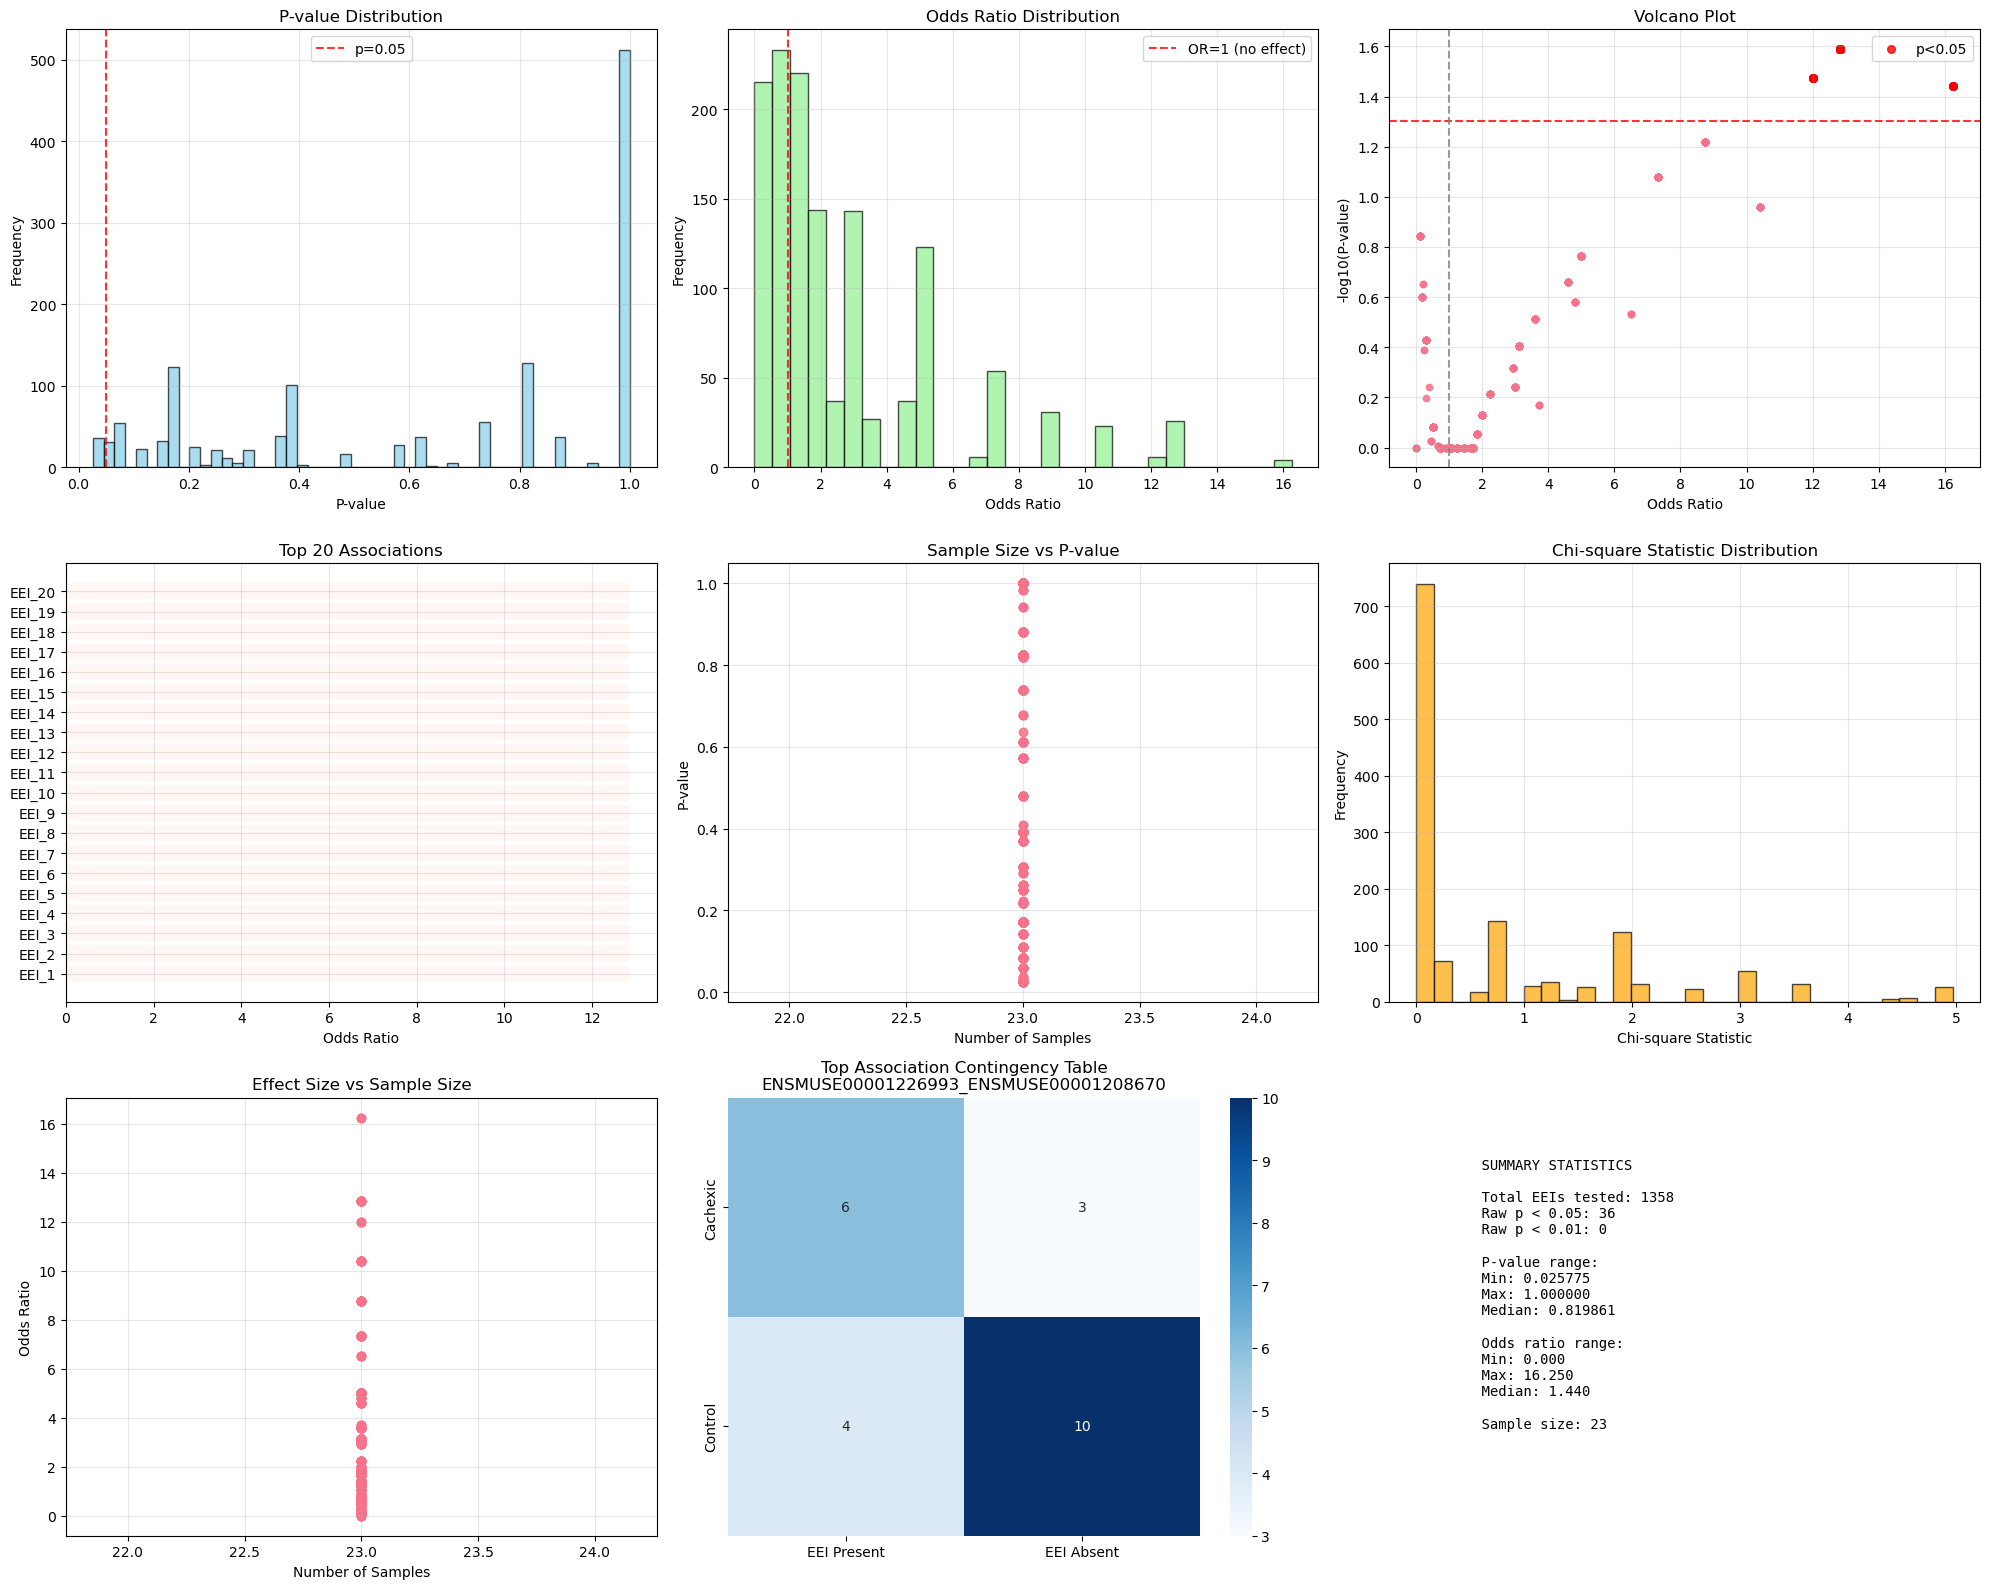

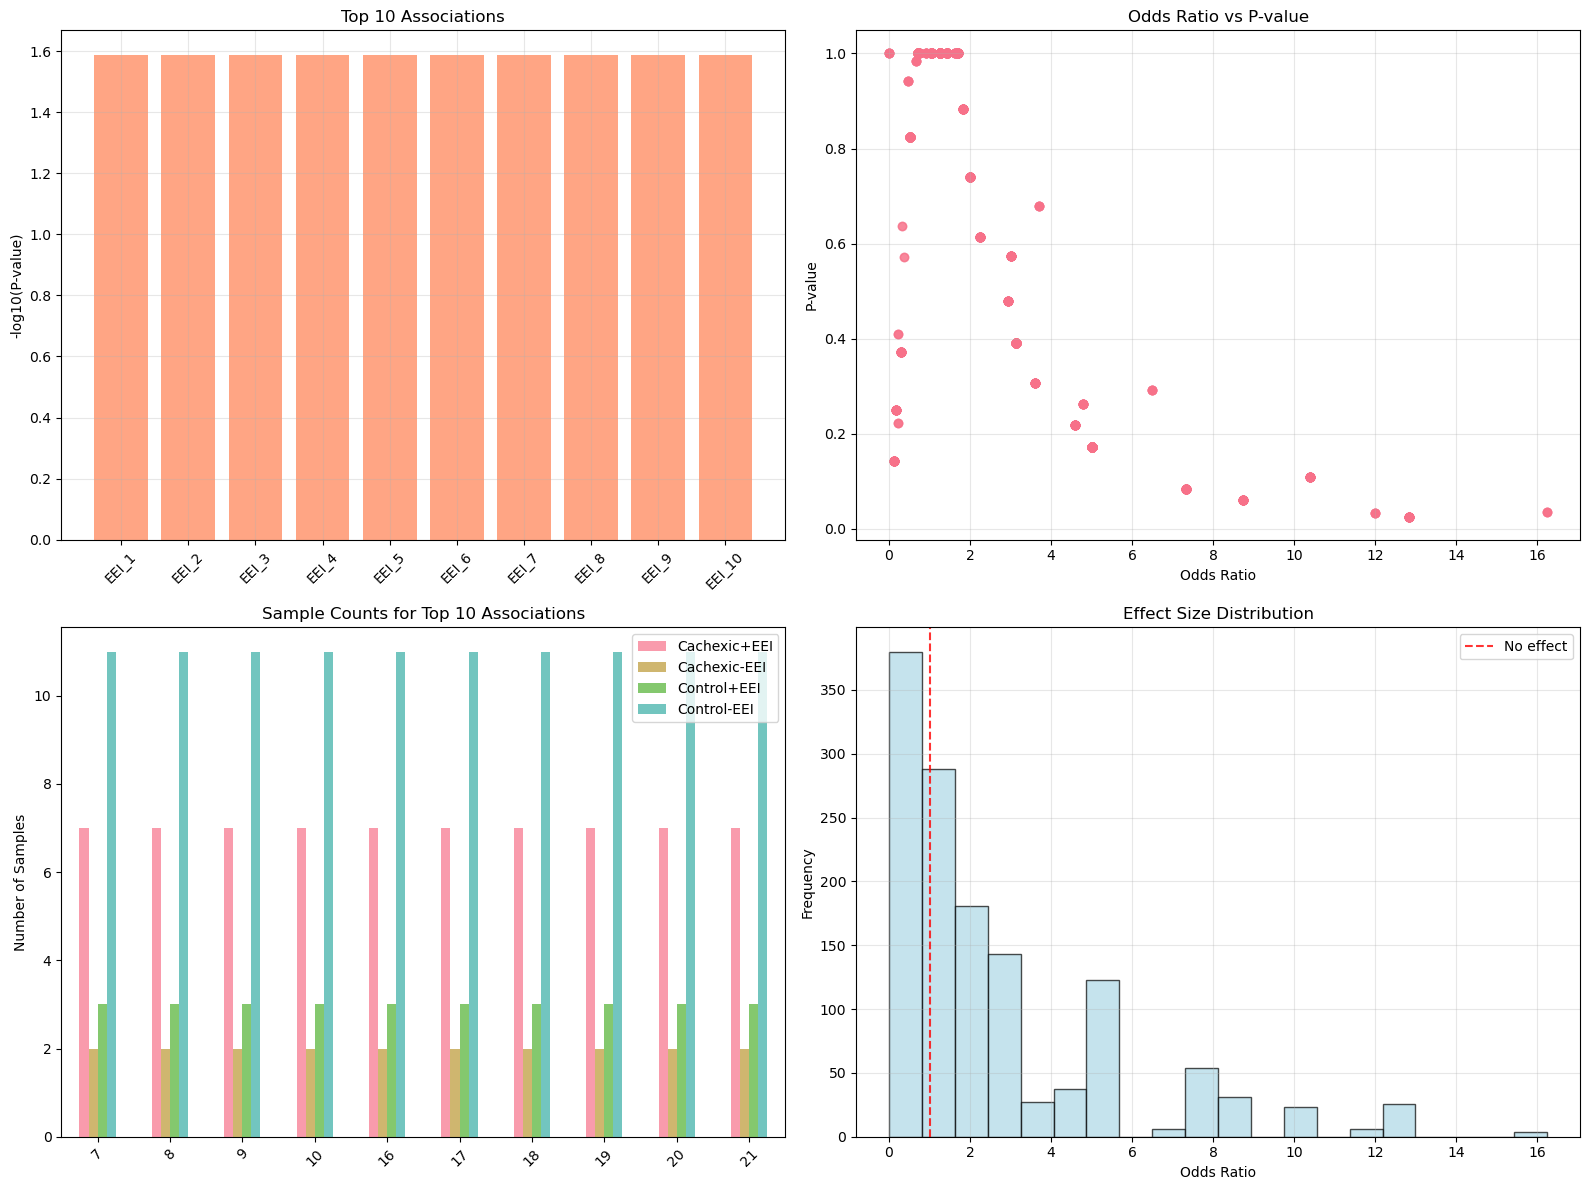


=== DETAILED RESULTS TABLE (Top 20) ===
 Rank                                EEI_ID              Exon1              Exon2  P_value Odds_ratio  Chi2  Cachexic+EEI  Cachexic-EEI  Control+EEI  Control-EEI  Total_samples
    1 ENSMUSE00001257880_ENSMUSE00000283464 ENSMUSE00001257880 ENSMUSE00000283464 0.025775     12.833 4.971             7             2            3           11             23
    2 ENSMUSE00001257880_ENSMUSE00000283442 ENSMUSE00001257880 ENSMUSE00000283442 0.025775     12.833 4.971             7             2            3           11             23
    3 ENSMUSE00001257880_ENSMUSE00000283406 ENSMUSE00001257880 ENSMUSE00000283406 0.025775     12.833 4.971             7             2            3           11             23
    4 ENSMUSE00001257880_ENSMUSE00000283371 ENSMUSE00001257880 ENSMUSE00000283371 0.025775     12.833 4.971             7             2            3           11             23
    5 ENSMUSE00001299390_ENSMUSE00000974847 ENSMUSE00001299390 ENSMUSE0000

In [86]:

# Run the visualizations
if cachexia_eei_results is not None:
    # Create visualizations
    fig1, fig2 = visualize_eei_cachexia_results(cachexia_eei_results)
    
    # Create results table
    results_table = create_results_table(cachexia_eei_results)
    
    # Save results
    save_results(cachexia_eei_results)
else:
    print("No results to visualize")

In [1]:
import pandas as pd
# Load the FPKM matrix
df = pd.read_csv("geo_data/GSE101336_processed_matrix_FPKM.txt", sep="\t")

# Optional: check shape and column names
print("Shape:", df.shape)
print("Columns:", df.columns[:5])

# Set 'gene_id' as index and drop non-expression columns
expression_df = df.set_index("gene_id").drop(columns=["tss_id", "locus"])

# Transpose so rows = mice, columns = genes
mouse_expression = expression_df.T
mouse_expression.index.name = "mouse_id"

# Preview
mouse_expression.head()


Shape: (23699, 20)
Columns: Index(['gene_id', 'tss_id', 'locus', 'BM663_mouse_1_KPC_HOP_DAC',
       'BM667_mouse_2_KPC_HOP_DAC'],
      dtype='object')


gene_id,Xkr4,Rp1,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Npbwr1,...,LOC100040031,LOC382133,LOC380994,LOC380994,LOC434960,LOC100041223,LOC100039614,LOC100039574,LOC100039753,LOC100039614
mouse_id,,,,,,,,,,,,,,,,,,,,,
BM663_mouse_1_KPC_HOP_DAC,0.762133,0.012835,3.09444,11.69010,35.1607,30.6228,0.688941,42.4142,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BM667_mouse_2_KPC_HOP_DAC,0.342516,0.002989,3.40150,12.04460,31.2182,25.4964,2.877820,32.3490,0.004871,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BM726_mouse_3_KPC_HOP_DAC,0.319399,0.016945,13.41690,16.13140,39.1441,38.7101,2.318680,47.1371,0.024536,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BM730_mouse_4_KPC_HOP_PBS,0.155230,0.016914,3.08946,8.04877,26.5912,34.0838,1.295720,38.3317,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BM731_mouse_5_KPC_HOP_PBS,0.346664,0.025684,14.63660,14.70480,35.0646,35.4109,3.233860,45.2328,0.020488,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
mouse_expression.head

<bound method NDFrame.head of gene_id                                     Xkr4       Rp1      Sox17  \
mouse_id                                                                
BM663_mouse_1_KPC_HOP_DAC               0.762133  0.012835   3.094440   
BM667_mouse_2_KPC_HOP_DAC               0.342516  0.002989   3.401500   
BM726_mouse_3_KPC_HOP_DAC               0.319399  0.016945  13.416900   
BM730_mouse_4_KPC_HOP_PBS               0.155230  0.016914   3.089460   
BM731_mouse_5_KPC_HOP_PBS               0.346664  0.025684  14.636600   
BM878_mouse_6_KPC_HOP_PBS               0.474067  0.003287   6.350050   
BM1101_mouse_7_allograft_DAC            0.534845  0.000000   0.714054   
BM1102_mouse_7_allograft_untreated      0.342265  0.013189   0.845410   
BM1103_mouse_8_allograft_DAC            0.470582  0.028385   0.516358   
BM1104_mouse_8_allograft_untreated      0.362794  0.005420   0.890449   
BM1105_mouse_9_allograft_DAC            0.301434  0.033624   0.964145   
BM1106_mouse_9_allogr

In [2]:
mouse_expression.to_csv("geo_data/mouse_expression.tsv", sep="\t")

In [2]:
import pandas as pd
df = pd.read_csv('geo_data/mouse_expression.tsv', sep='\t', index_col=0)
df = df.T
df.head()

mouse_id,BM663_mouse_1_KPC_HOP_DAC,BM667_mouse_2_KPC_HOP_DAC,BM726_mouse_3_KPC_HOP_DAC,BM730_mouse_4_KPC_HOP_PBS,BM731_mouse_5_KPC_HOP_PBS,BM878_mouse_6_KPC_HOP_PBS,BM1101_mouse_7_allograft_DAC,BM1102_mouse_7_allograft_untreated,BM1103_mouse_8_allograft_DAC,BM1104_mouse_8_allograft_untreated,BM1105_mouse_9_allograft_DAC,BM1106_mouse_9_allograft_untreated,BM1107_mouse_10_allograft_DAC,BM1108_mouse_10_allograft_untreated,BM9818_mouse_11_KPC_cutltured_control,BM9819_mouse_11_KPC_cutltured_DAC_5uM,BM9820_mouse_11_KPC_cutltured_DAC_10uM
Xkr4,0.762133,0.342516,0.319399,0.155230,0.346664,0.474067,0.534845,0.342265,0.470582,0.362794,0.301434,0.264450,0.350457,0.281049,0.062316,0.070254,0.059634
Rp1,0.012835,0.002989,0.016945,0.016914,0.025684,0.003287,0.000000,0.013189,0.028385,0.005420,0.033624,0.007415,0.002947,0.002449,0.000000,0.006634,0.002345
Sox17,3.094440,3.401500,13.416900,3.089460,14.636600,6.350050,0.714054,0.845410,0.516358,0.890449,0.964145,0.389080,1.480510,0.536560,0.140247,0.082213,0.180310
Mrpl15,11.690100,12.044600,16.131400,8.048770,14.704800,13.340000,15.307600,15.921400,19.121100,16.571400,13.926700,15.325900,15.298900,16.617200,16.170600,18.640000,19.413500
Lypla1,35.160700,31.218200,39.144100,26.591200,35.064600,30.399700,34.627700,38.779900,39.562300,38.701600,37.102200,40.372000,35.373600,37.914300,28.026200,31.391300,28.851100


In [3]:
df.to_csv('geo_data/mouse_expression_transposed.tsv', sep='\t')